## Summary 

The optimal model we choose for one hidden layer has the parameters as following: learning rate 0.3, weight decay 0.001, batch size 200 and max epochs 50 with Softmax Cross Entropy loss and ReLU activation. The accuracy on the test set reaches to 0.9768. For two hidden layers, we tested both Softmax Cross Entropy loss and Euclidean loss with ReLU activation. Their accuracy scores both reach 0.98, among which MSE is slightly better with an accuracy at 0.9811.

The balance between batch size, max epoch, learning rate and weight decay, has decisive influences over the learning results. Neuron amount in one hidden layer, that is how wide a layer/model is, also has huge impact over the training results. If less number of neurons is chosen it will lead to underfitting and high statistical bias. Whereas if we choose too many neurons it may lead to overfitting, high variance, and increases the time it takes to train the network.

In our experiment, ReLU works generally better than Sigmoid. sigmoid outputs are not zero-centered. This is undesirable since neurons in later layers of processing in a Neural Network (more on this soon) would be receiving data that is not zero-centered. This has implications on the dynamics during gradient descent, because if the data coming into a neuron is always positive (e.g. x>0 elementwise in f=wTx+b)), then the gradient on the weights w will during backpropagation become either all be positive, or all negative (depending on the gradient of the whole expression f). This could introduce undesirable zig-zagging dynamics in the gradient updates for the weights.

With more time, we could try use early-stop strategy and Adam in the MLP and see how network behaves. Besides, given the two-hidden-layer networks with softmax and MSE have similar accuracy on the test set, we should run tests to check which one is better with statistical significance.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from network import Network
from solver import train, test
from plot import plot_loss_and_acc
from criterion import EuclideanLossLayer, SoftmaxCrossEntropyLossLayer
from optimizer import SGD
from layers import FCLayer, SigmoidLayer, ReLULayer

## 1. Data Preprocessing

The data is directly pulled down by tensorflow keras. It is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.  
Gray-scale information at each pixel is regularized, and labels are converted to one-hot matrix form for regression/classification on multiple classes.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def decode_image(image):
    # regularization/normalization
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [784])
    image = image / 255.0
    image = image - tf.reduce_mean(image)
    return image

def decode_label(label):
    # convert groundtruth labels to one-hot
    return tf.one_hot(label, depth=10)

In [4]:
# Pre-processing data to have proper train set and test set
x_train = tf.data.Dataset.from_tensor_slices(x_train).map(decode_image)
y_train = tf.data.Dataset.from_tensor_slices(y_train).map(decode_label)
data_train = tf.data.Dataset.zip((x_train, y_train))

x_test = tf.data.Dataset.from_tensor_slices(x_test).map(decode_image)
y_test = tf.data.Dataset.from_tensor_slices(y_test).map(decode_label)
data_test = tf.data.Dataset.zip((x_test, y_test))

## 2. Paramter Tuning for MLP with Euclidean Loss

In Section 2 and 3, we will compare different hyperparameter settings and how they work with MLP with only one hidden layer. The MLP network models used are:  
1. MLP with Euclidean Loss and ReLU Activation
2. MLP with Euclidean Loss and Sigmoid Activation
3. MLP with Softmax Cross Entropy Loss and ReLU Activation
4. MLP with Softmax Cross Entropy Loss and Sigmoid Activation

### 2.1 Batch size

Batch sizes for testing are: 50, 100, 200, 500, 1000.  

ref: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/  
The number of training examples used in the estimate of the error gradient is a hyperparameter for the learning algorithm called the “batch size,” or simply the “batch.”  

Smaller batch sizes are normally used for:
1. Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error;
2. Smaller batch sizes make it easier to fit one batch worth of training data in memory.
Large batch sizes usually suggest more stable gradients.  

We will start with max epoch 20, learning rate 0.1 and weight decay 0.01.

In [6]:
max_epoch = 20
init_std = 0.01
learning_rate_SGD = 0.1
weight_decay = 0.01
disp_freq = 100

criterion = EuclideanLossLayer()
sgd = SGD(learning_rate_SGD, weight_decay)

### 2.1.1 MLP with Euclidean Loss and Sigmoid Activation

In [6]:
sigmoidMLP = Network()
sigmoidMLP.add(FCLayer(784, 128)) # 128 is the amount of neural units in a hidden layer
sigmoidMLP.add(SigmoidLayer())
sigmoidMLP.add(FCLayer(128, 10))

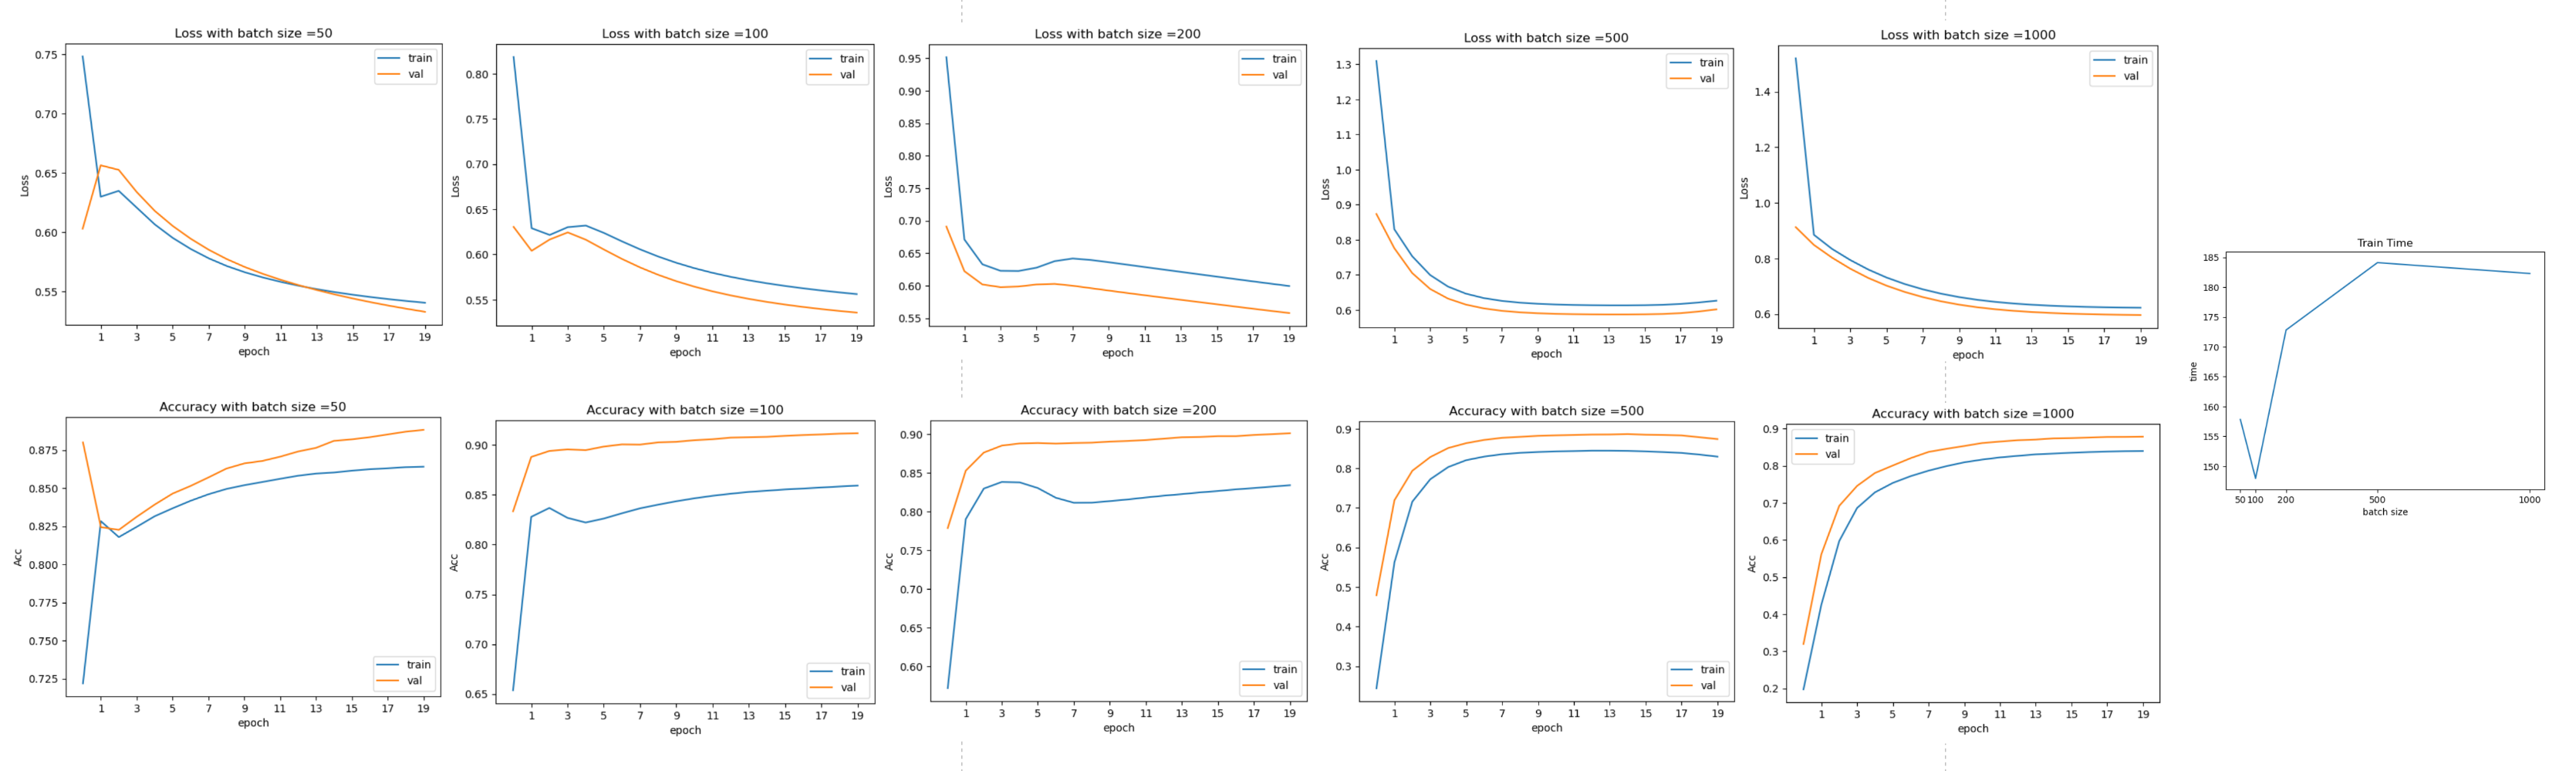

Almost no underfitting happens in the group of experiments.  
ref: https://stats.stackexchange.com/questions/512101/training-loss-decreases-then-suddenly-increases-then-decreases-lower-than-the  
ref: https://www.allaboutcircuits.com/technical-articles/understanding-local-minima-in-neural-network-training/  
Before batch size is beyond 500, local oscillation happens at quite early stage of training(small epoch). Loss on the train set and validation set both decrease, then increase and decrese again. One possible explanation is that  the optimizer pushes the network out of minimum and then the loss decreases healthily again towards a different local minimum. And the second downward trend leads to a much lower loss and higher accuracy. This mean the first local minimum may be no where near the global minimum.  
When batch size is 500, the loss starts to grow after epoch reaches 13, and at the same time, the accuracy drops. This is overfitting, due to we train too much on the train set. Good convergemce happens when batch size is 1000 as the loss tends to be stable. However, the loss from batch size 100 is much lower than batch size 1000 and still keeps decreasing. Also, take account the train budget(time), we will use batch size 100 for later test.

### 2.1.2 MLP with Euclidean Loss and ReLU Activation

In [9]:
reluMLP = Network()
reluMLP.add(FCLayer(784, 128))
reluMLP.add(ReLULayer())
reluMLP.add(FCLayer(128, 10))

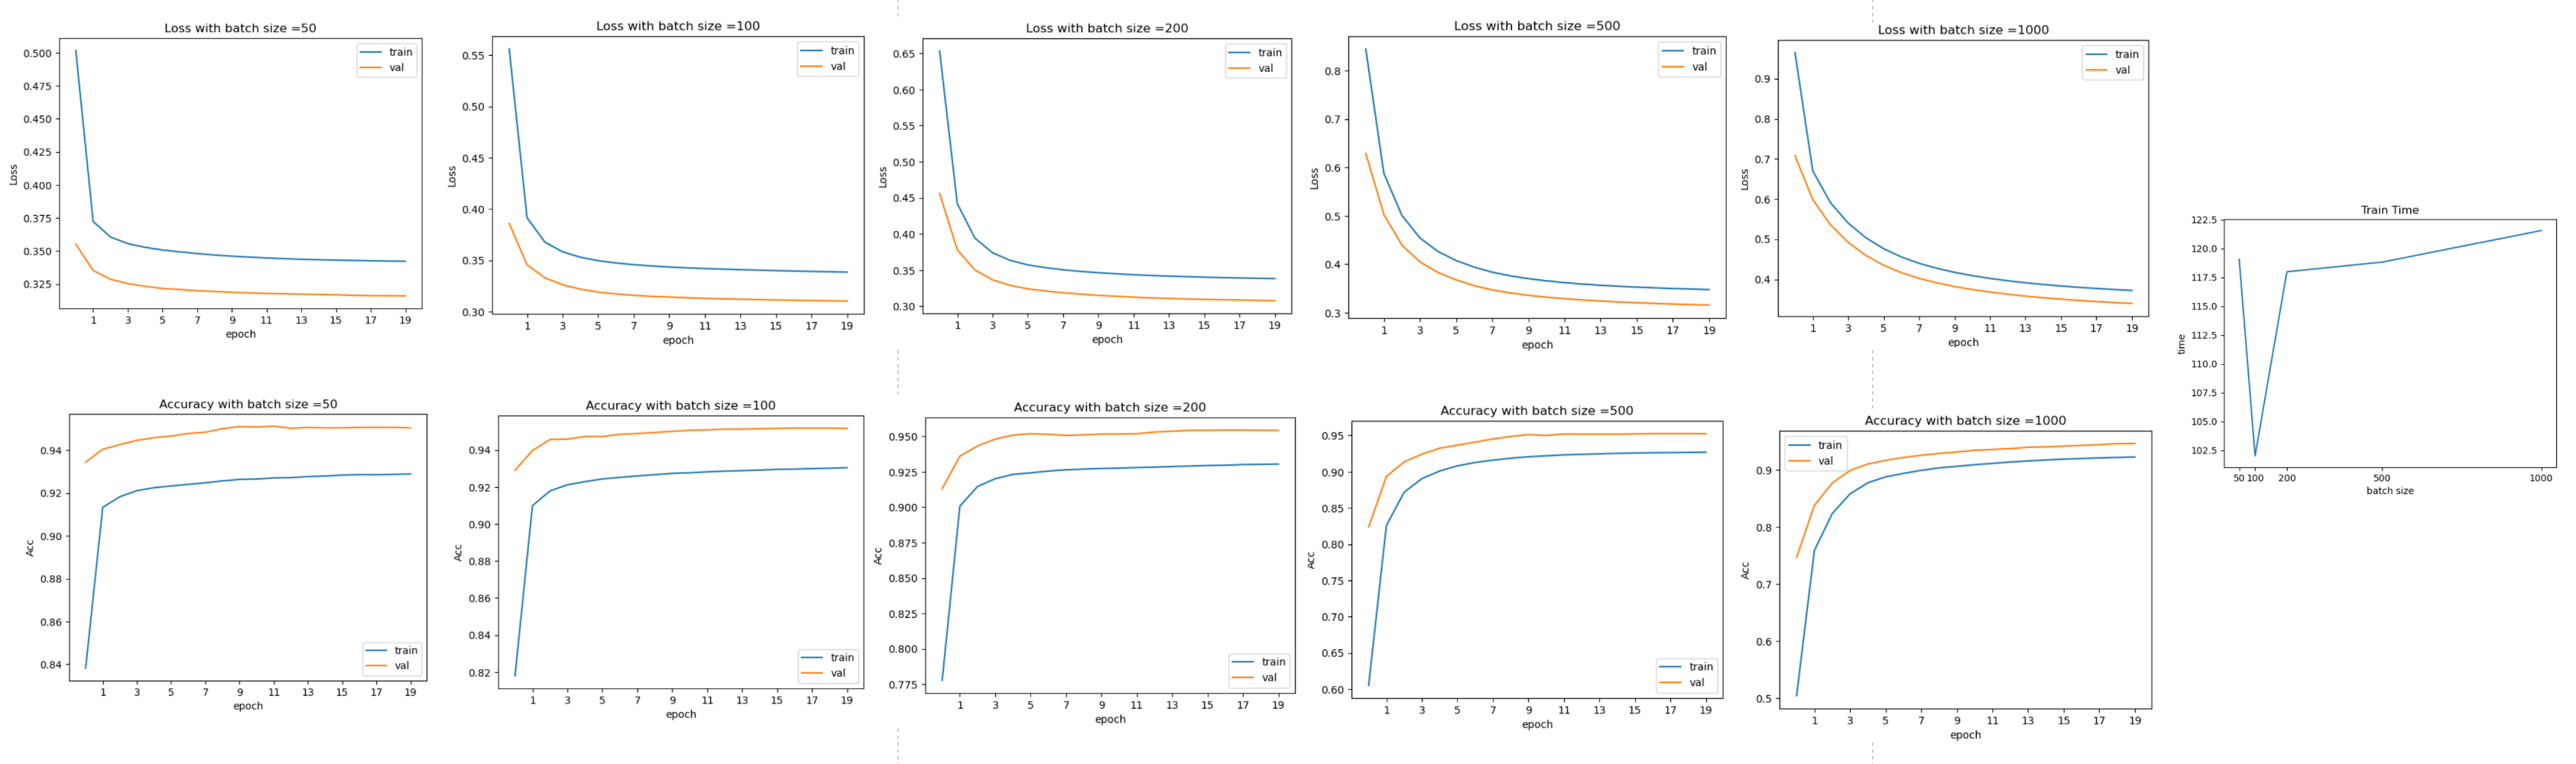

Using ReLU as activation function does not lead to local mimimum as much as using Sigmoid. One reason may be ReLu has benefits that reduced likelihood of the gradient to vanish. In contrast, the gradient of sigmoids becomes increasingly small and the model will have difficulty in converge to global optimal.  
ref: https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks  
ReLU is also more computationally efficient to compute than Sigmoid like functions since Relu just needs to pick max(0,x
) and not perform expensive exponential operations as in Sigmoids.  
Batch size 200 has the smoothest loss curves and accuracy curves and second lowest training cost. The converge happens fast on this model. Therefore, we will use it for tuning epoch settings.

### 2.2 Max Epoch

Seen from last section, we could notice that non global optimal happens before epoch reaches 10. Thus, we will start testing max epoch from this anchor.
Batch sizes for testing are: 10, 16, 24, 32, 64.

Overfitting can happen if the model trains so much on the training data. We can also get a glimps of this through diagrams from the previous section. Take 2.1.1 with batch size 500, the loss starts to increase and accuracy starts to drop after the epoch reaches 15. We need to joint control the model with epoch and batch size. One example is epoch usually increses when the batch size grows.

### 2.2.1 MLP with Euclidean Loss and Sigmoid Activation (Batch Size:100)

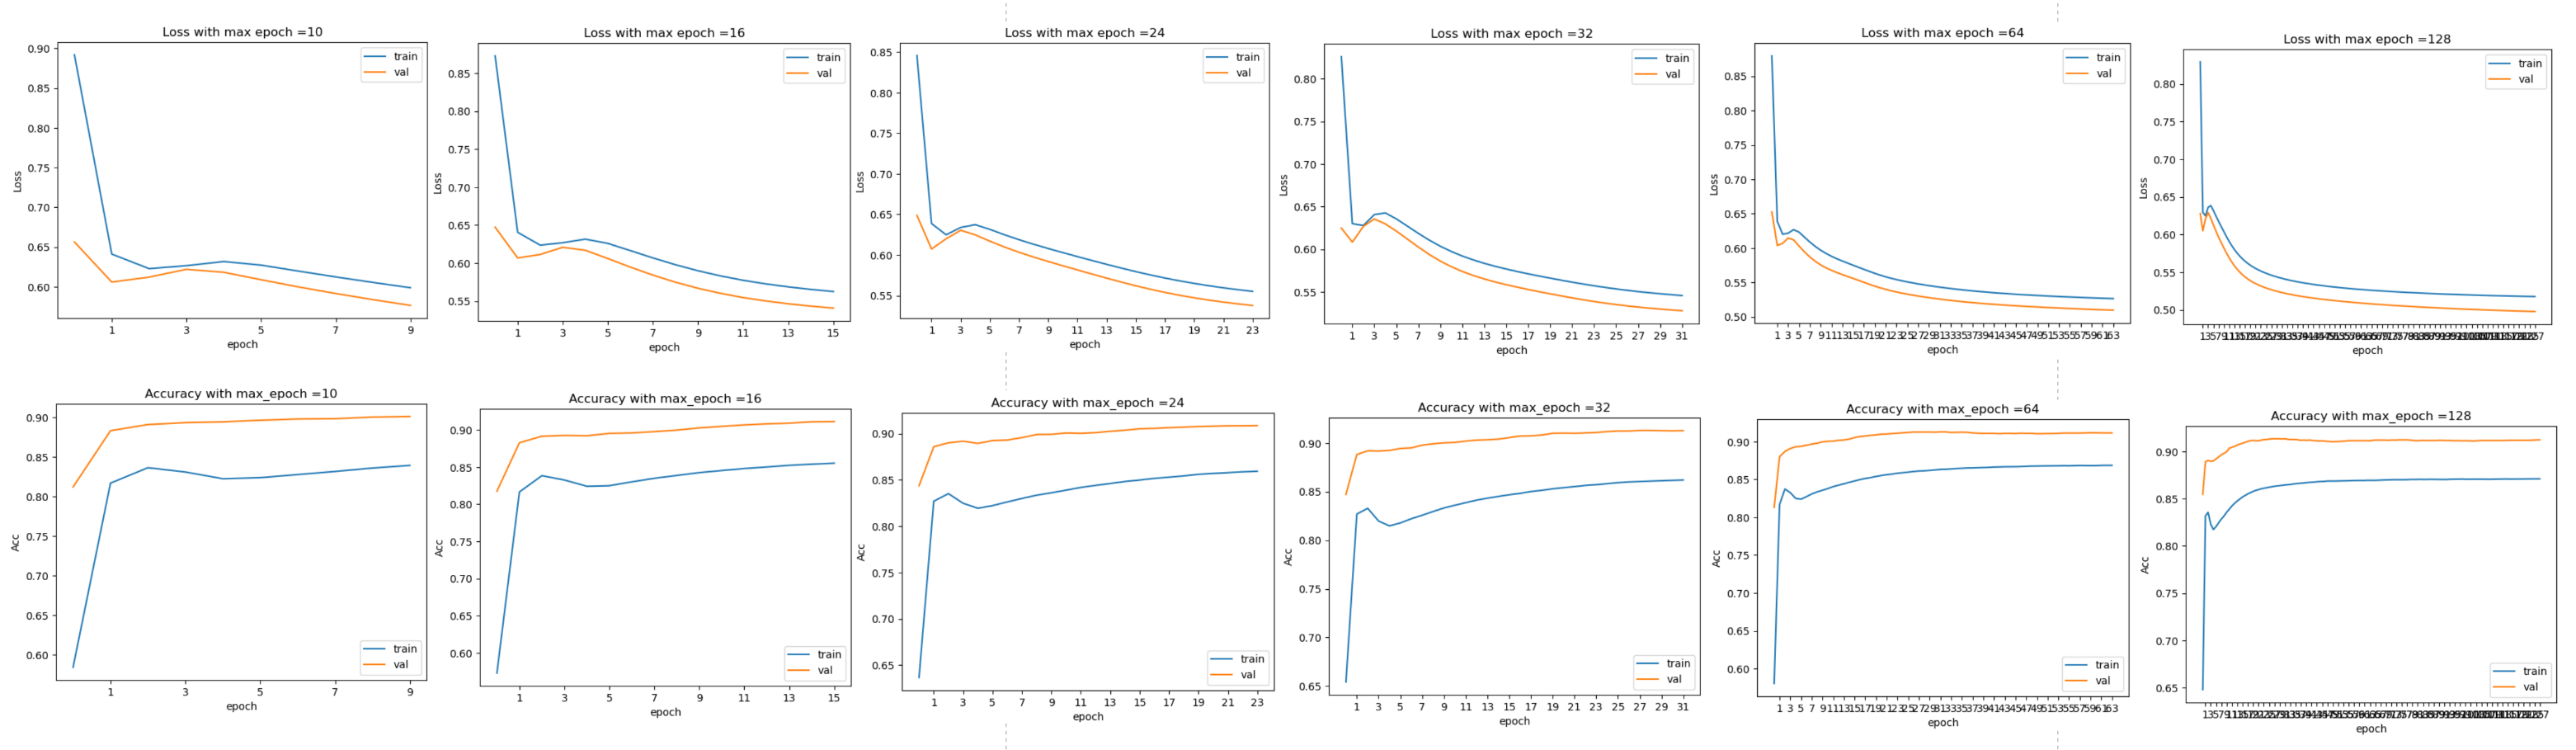

### 2.2.2 MLP with Euclidean Loss and ReLU Activation (Batch Size: 200)

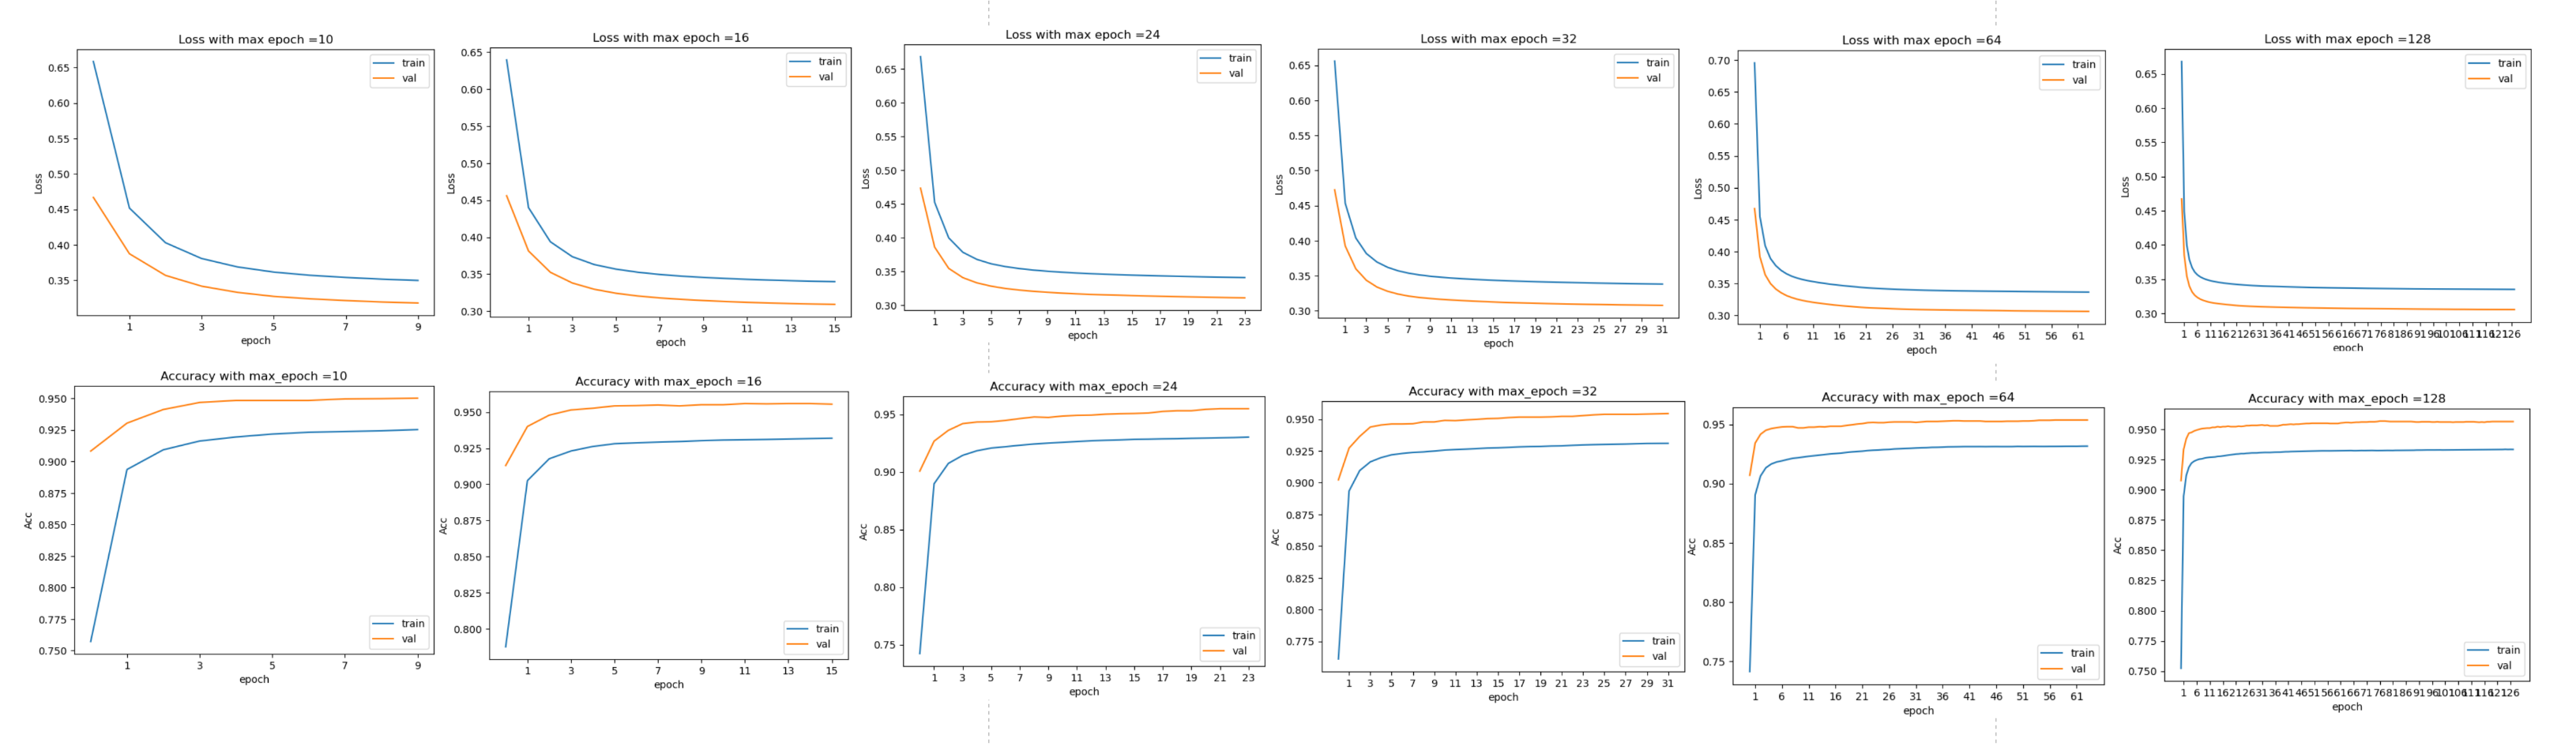

ref: https://stackoverflow.com/questions/43499199/tensorflow-loss-decreasing-but-accuracy-stable  
ref: https://liyin2015.medium.com/commonly-used-activation-functions-9821ed348217

1. Using ReLU as the activation function has faster convergence, lower loss and higher accuracy. The best performance is MLP with Euclidean Loss and ReLU Activation when batch size is 200 and epoch is around 43.
2. The network with ReLU converges fast before epoch 6 and becomes stable(almost converged) at around epoch 20.
3. After reaching a local minima, the loss curves always follow a downward trend as the epoch grows. As the max epoch reaches above 64, the accuracy starts to be stable. This is potentially because our netwrok starts to memorize data, and we need to consider some forms of drop out. In other words, our network has already converged and we need to consider other ways for regularization for better learning. 
4. In addition to 3, sigmoid outputs are not zero-centered. This is undesirable since neurons in later layers of processing in a Neural Network (more on this soon) would be receiving data that is not zero-centered. This has implications on the dynamics during gradient descent, because if the data coming into a neuron is always positive (e.g. x>0 elementwise in f=wTx+b)), then the gradient on the weights w will during backpropagation become either all be positive, or all negative (depending on the gradient of the whole expression f). This could introduce undesirable zig-zagging dynamics in the gradient updates for the weights.
5. In conclusion, using a one-hidden-layer MLP with ReLU activation and MSE works better on our data set. We will use this combination for later testing on neural unit amount, learning rate and weight decay.

## 2.3 Learning Rate, Weight Decay and Neuron Amount

ref: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw  

Below listed some some typical rules for choosing neuron amount:  
1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.  
Too fewer neurons will always result in underfitting, and too much can lead to overfitting. Below is a formular for reference:
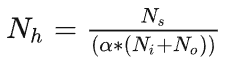
Therefore, we will test [30, 60, 75, 100, 128, 150] for neuron amount.

In [5]:
learning_rates = [0.001, 0.01, 0.1, 0.3, 0.5, 0.9]
decays = [0.001, 0.01, 0.1]
neurons = [60, 75, 100, 128, 150]

### 2.3.1 Learning Rate

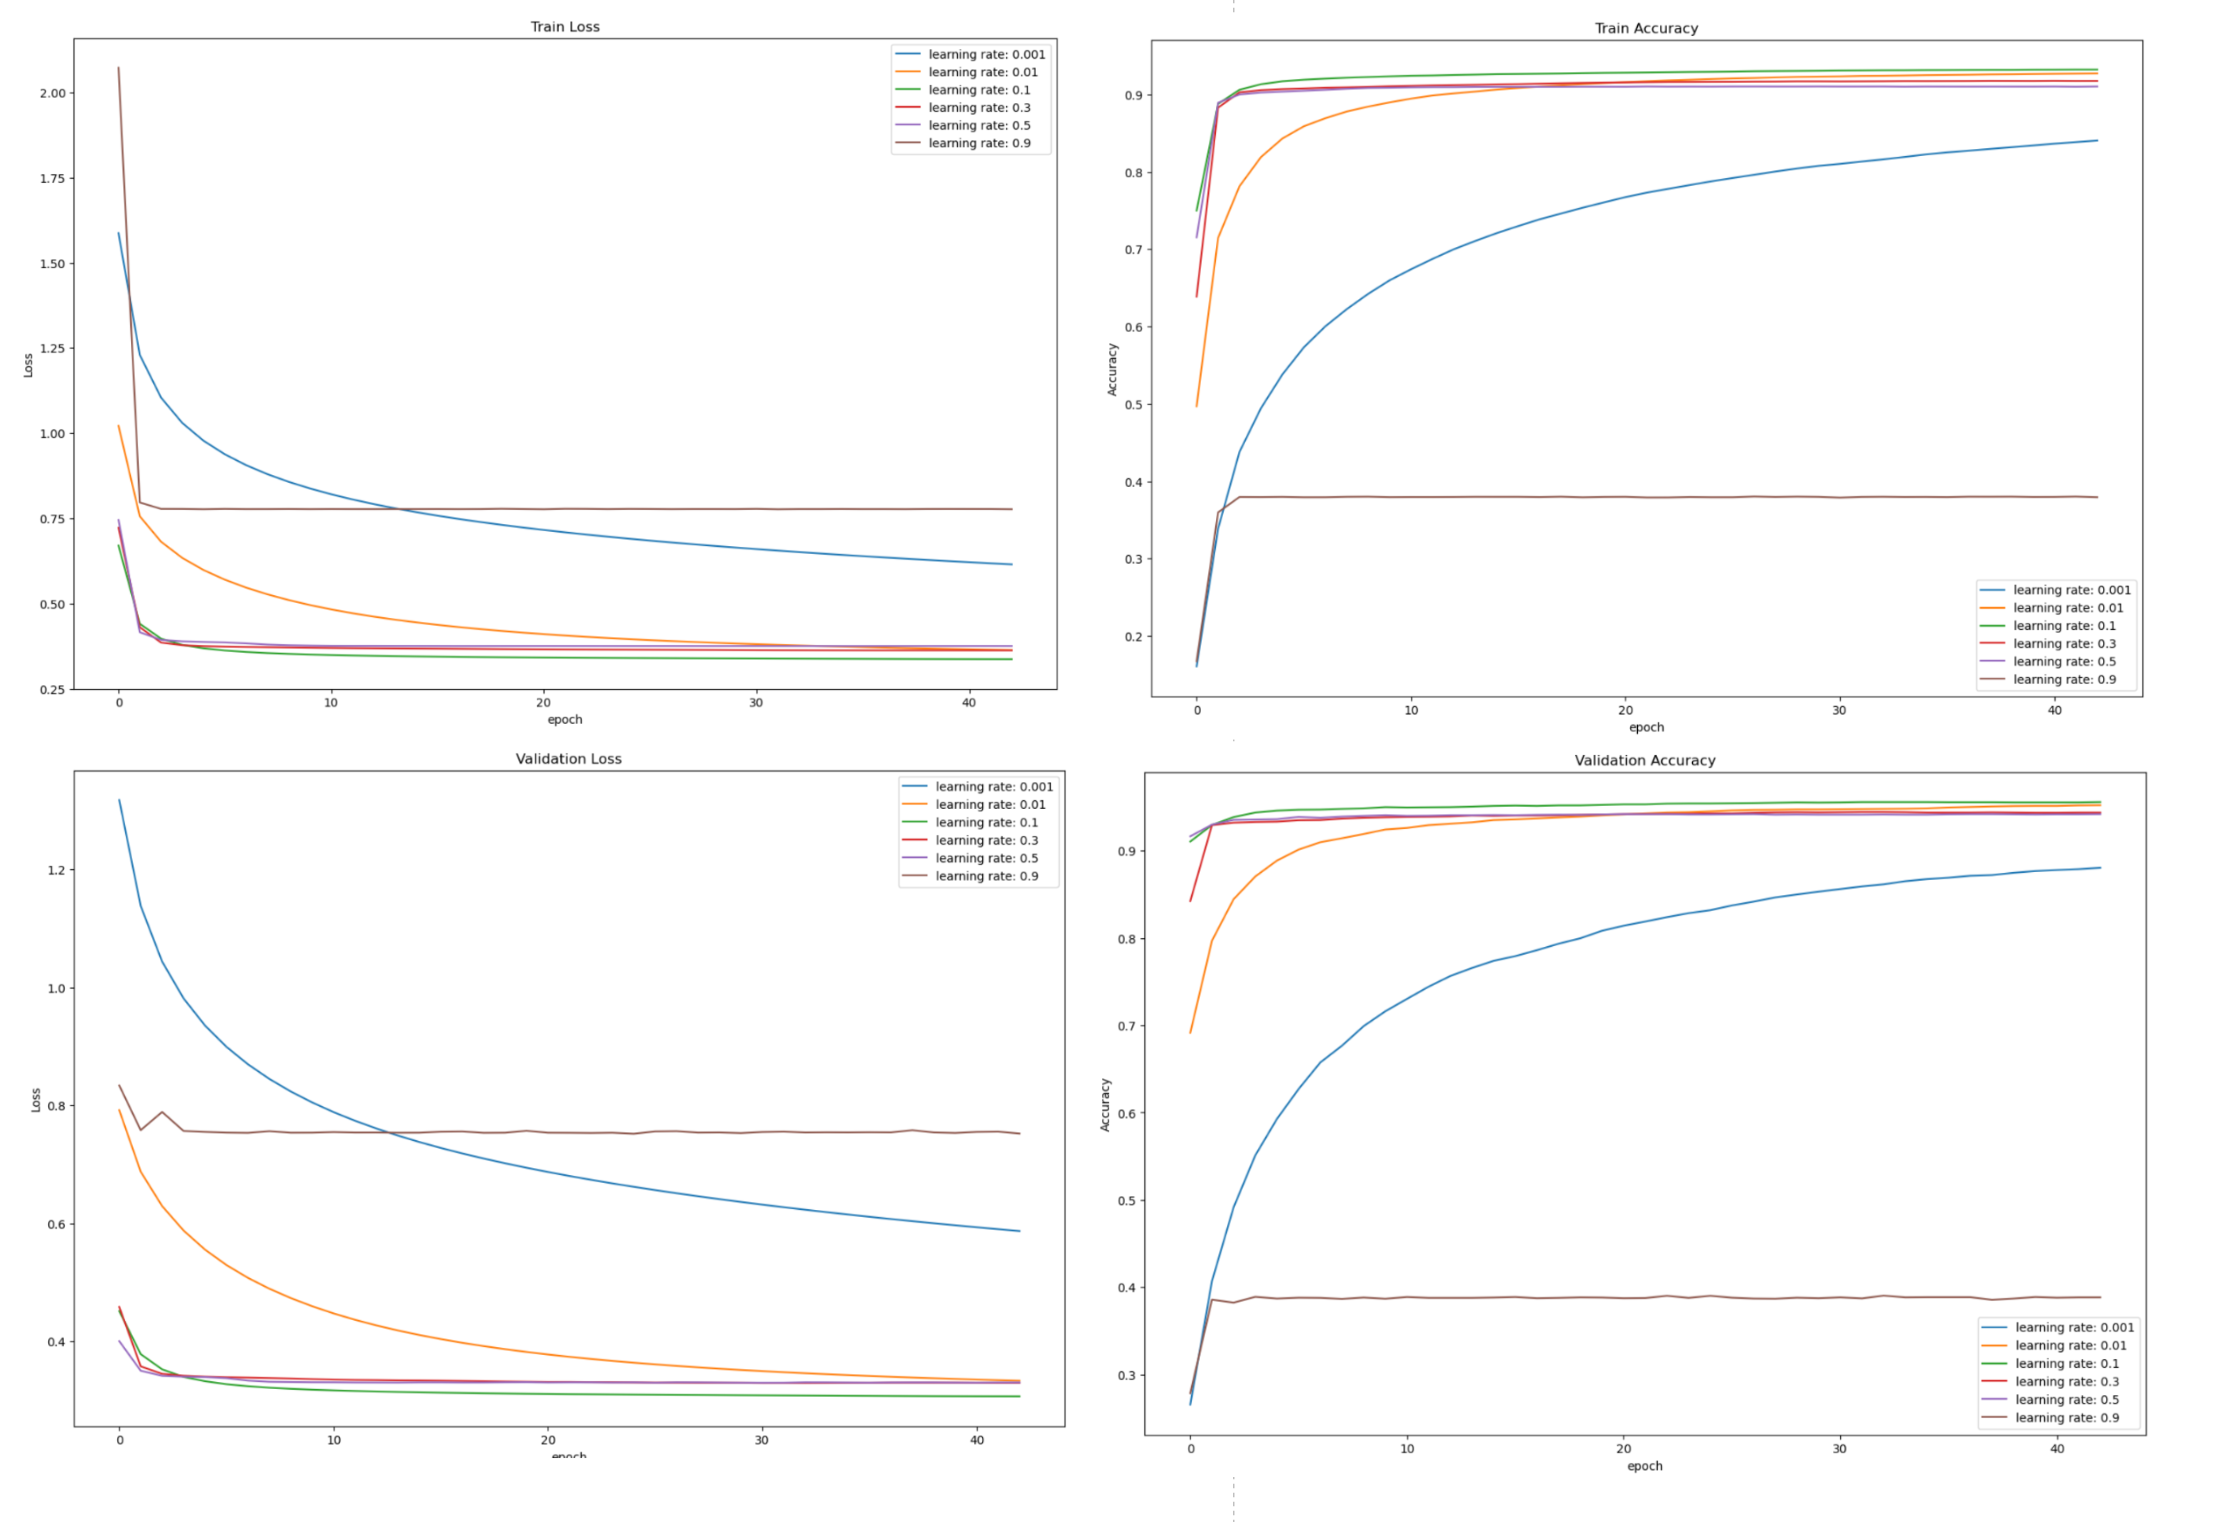

1. Learning rate at 0.001 and 0.9 carry out the worst performances on our data set. Learning rate 0.001 makes the metwork slow to converge and 0.9 makes the loss curves and accuracy fluctuates on the validation set. Too large learning rates will make the weght oscillate around the optimal, but always skip the best solution.
2. Networks' behaviours with learnig rate 0.01, 0.1, 0.3 and 0.5 are close. Among which 0.1 has the best learning results. It converges fast and has the highest prediction accuracy. 
Therefore, we will use 0.1 as the learning rate. One thing needs to be noted is that we will still use max epoch 43 to tuning weight decay and neuron amount settings. This is because all parameters work together in the training. Even our current settings(batch size: 200, max epoch: 43, weight decay: 0.01, neuron amount: 128) converge at around epoch 10, we could not be sure that this early converge will remain the same when other parameters gewt changed.

### 2.3.2 Weight Decay

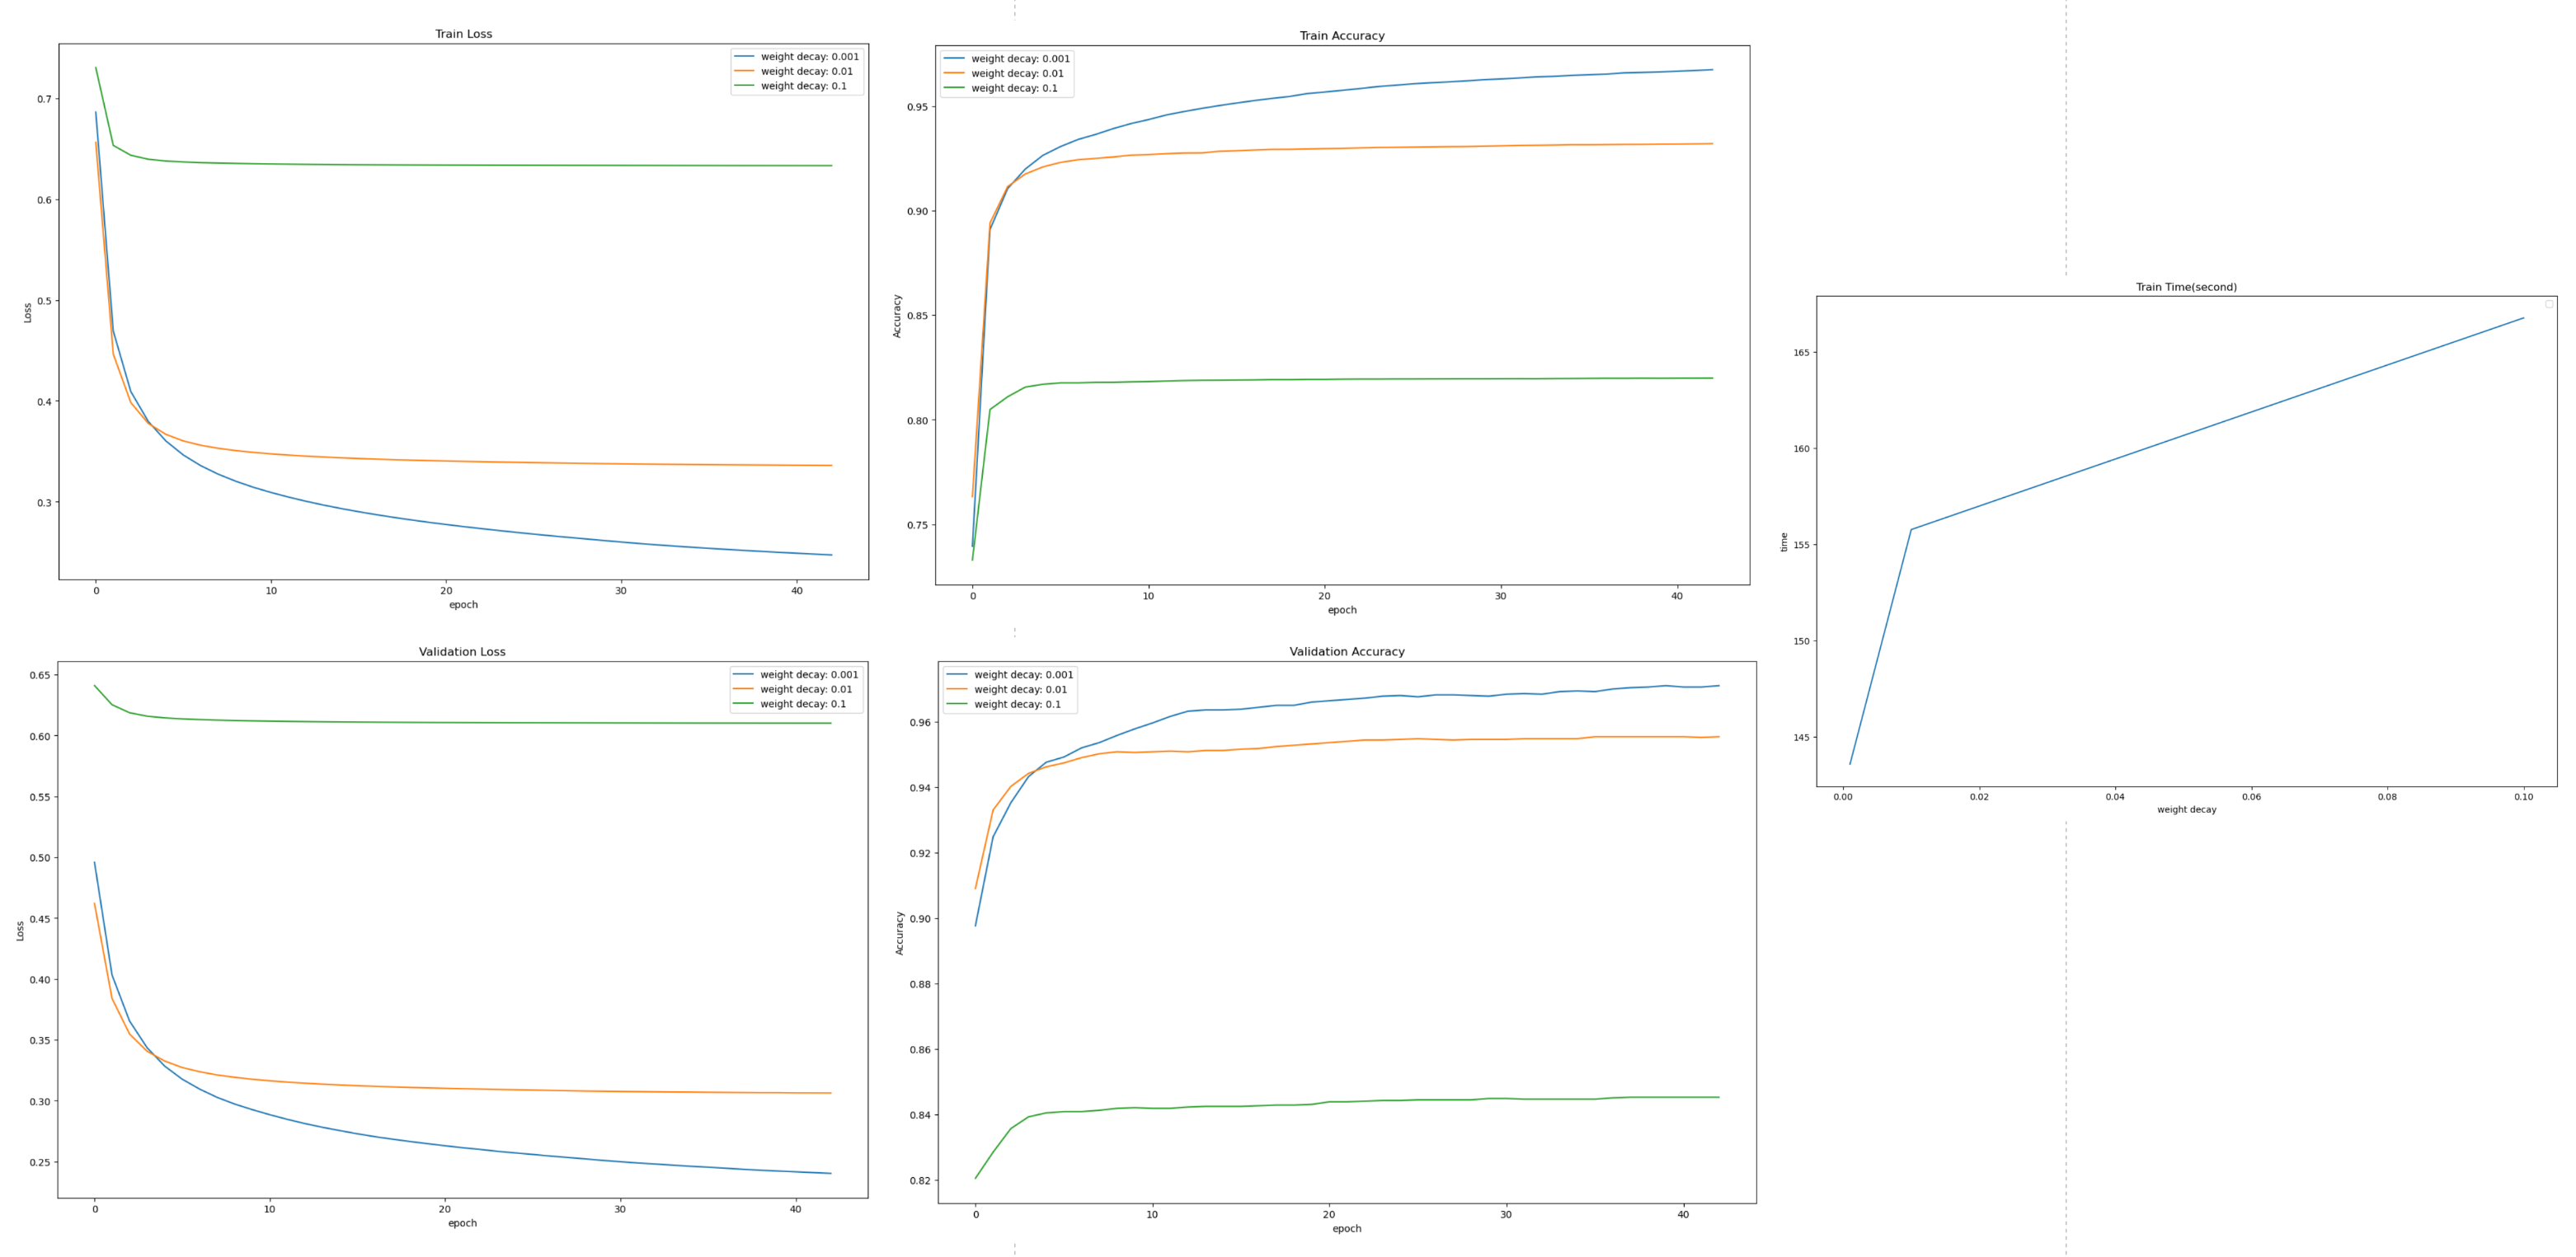

ref: https://towardsdatascience.com/weight-decay-and-its-peculiar-effects-66e0aee3e7b8  

Weight decay, sometimes referred to as L2 normalization (though they are not exactly the same, here is good blog post explaining the differences), is a common way to regularize neural networks. It helps the neural networks to learn smoother or simpler functions which most of the time generalizes better compared to spiky, noisy ones. Weight decay here acts as a method to lower the model’s capacity such that an over-fitting model does not overfit as much and gets pushed towards the sweet spot. This also shows that weight decay will have a negative impact if the model is originally operating in the under-fitting region.  

1. Weight decay at 0.1 has the worst performance among the values we test. Too large weight decay factors usually make the network underefir and have small weights that cannot capture the complexity of the data and classificaiton rules. 
2. Diagrams for weight decay at 0.001 suggests that the model has still not converged at the last epoch we run. The associated accuracy on calidatrion set fluctuates a lot. When the weight decay factor is too small, the network may still overfit and have large weights, that is, not converge.
3. Weight decay 0.01 has the smoothest loss and accuracy. The accuracy is around 0.95112 and loss is as low as 0.31840.
4. We will increase the epoch to 128 and see how the network converges with weight decay 0.001. 
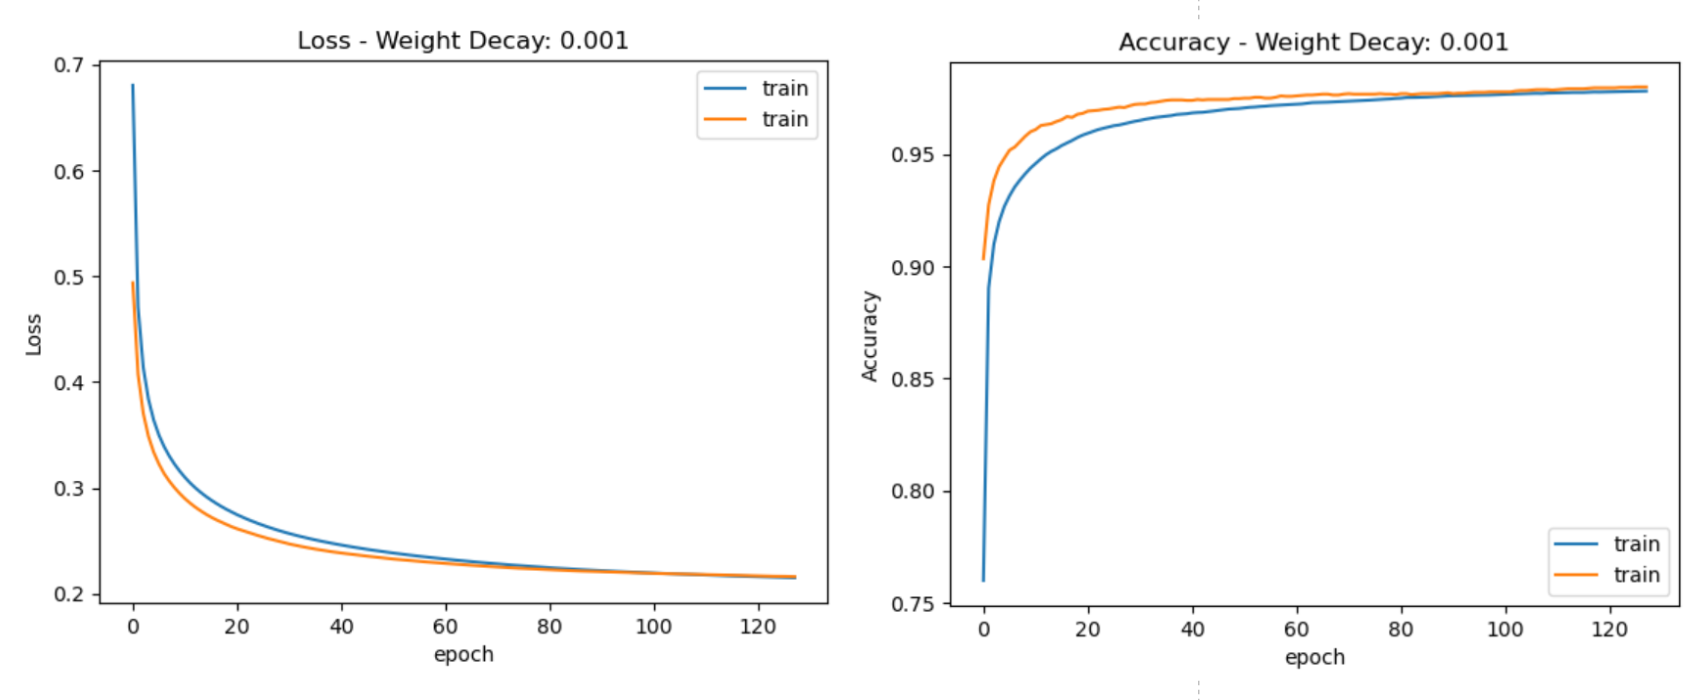
From the above diagram(orange is for validation performances), we could see that weight decay 0.001 has the lowest loss 0.24141 and highest accuracy 0.97282. Therefore, we will use it and the weight decay 0.01 to test neuron amount.

### 2.3.3 Neuron Amount

Batch Size: 200, Max Epoch: 128, Weight Decay: 0.001
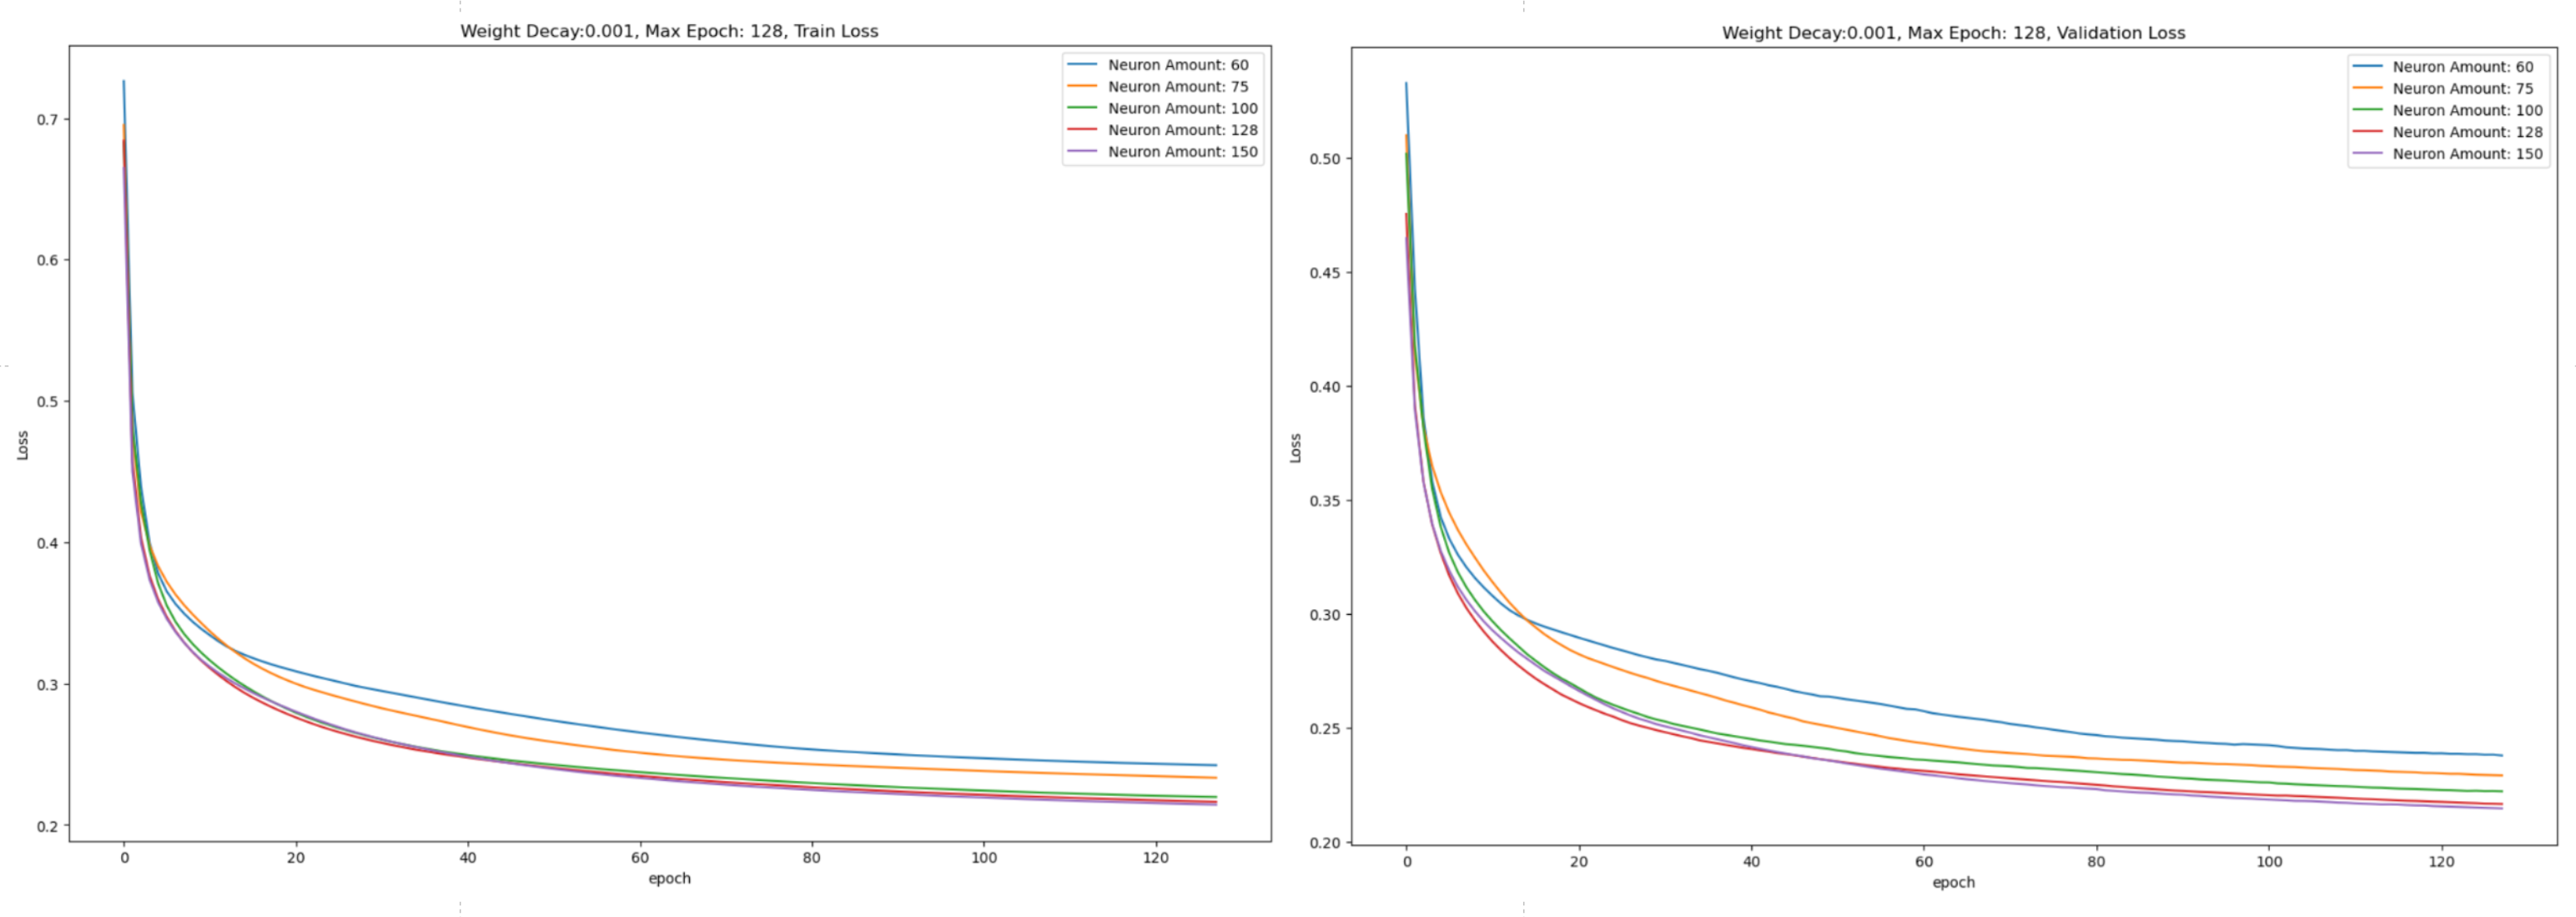
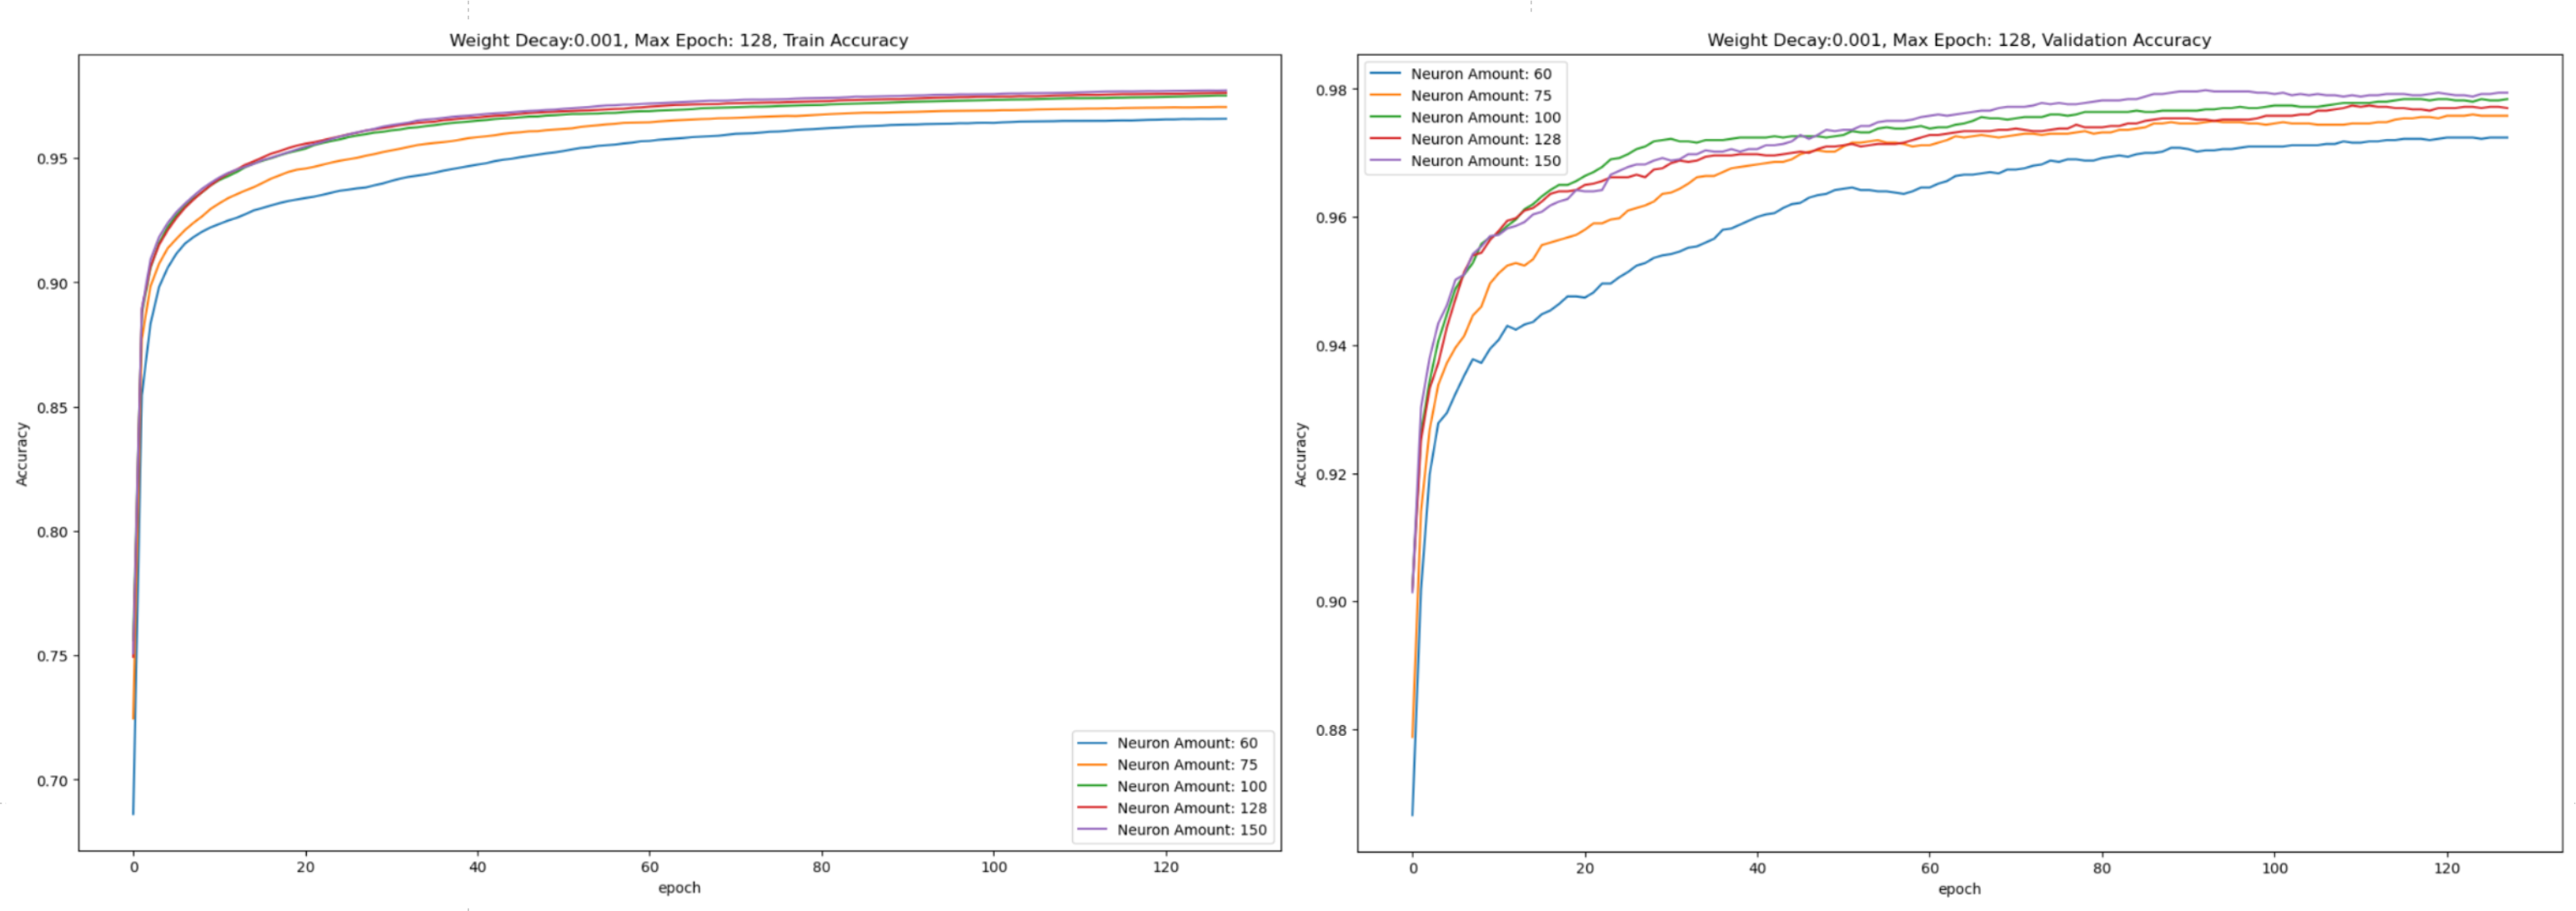

Batch Size: 200, Max Epoch: 43, Weight Decay: 0.01
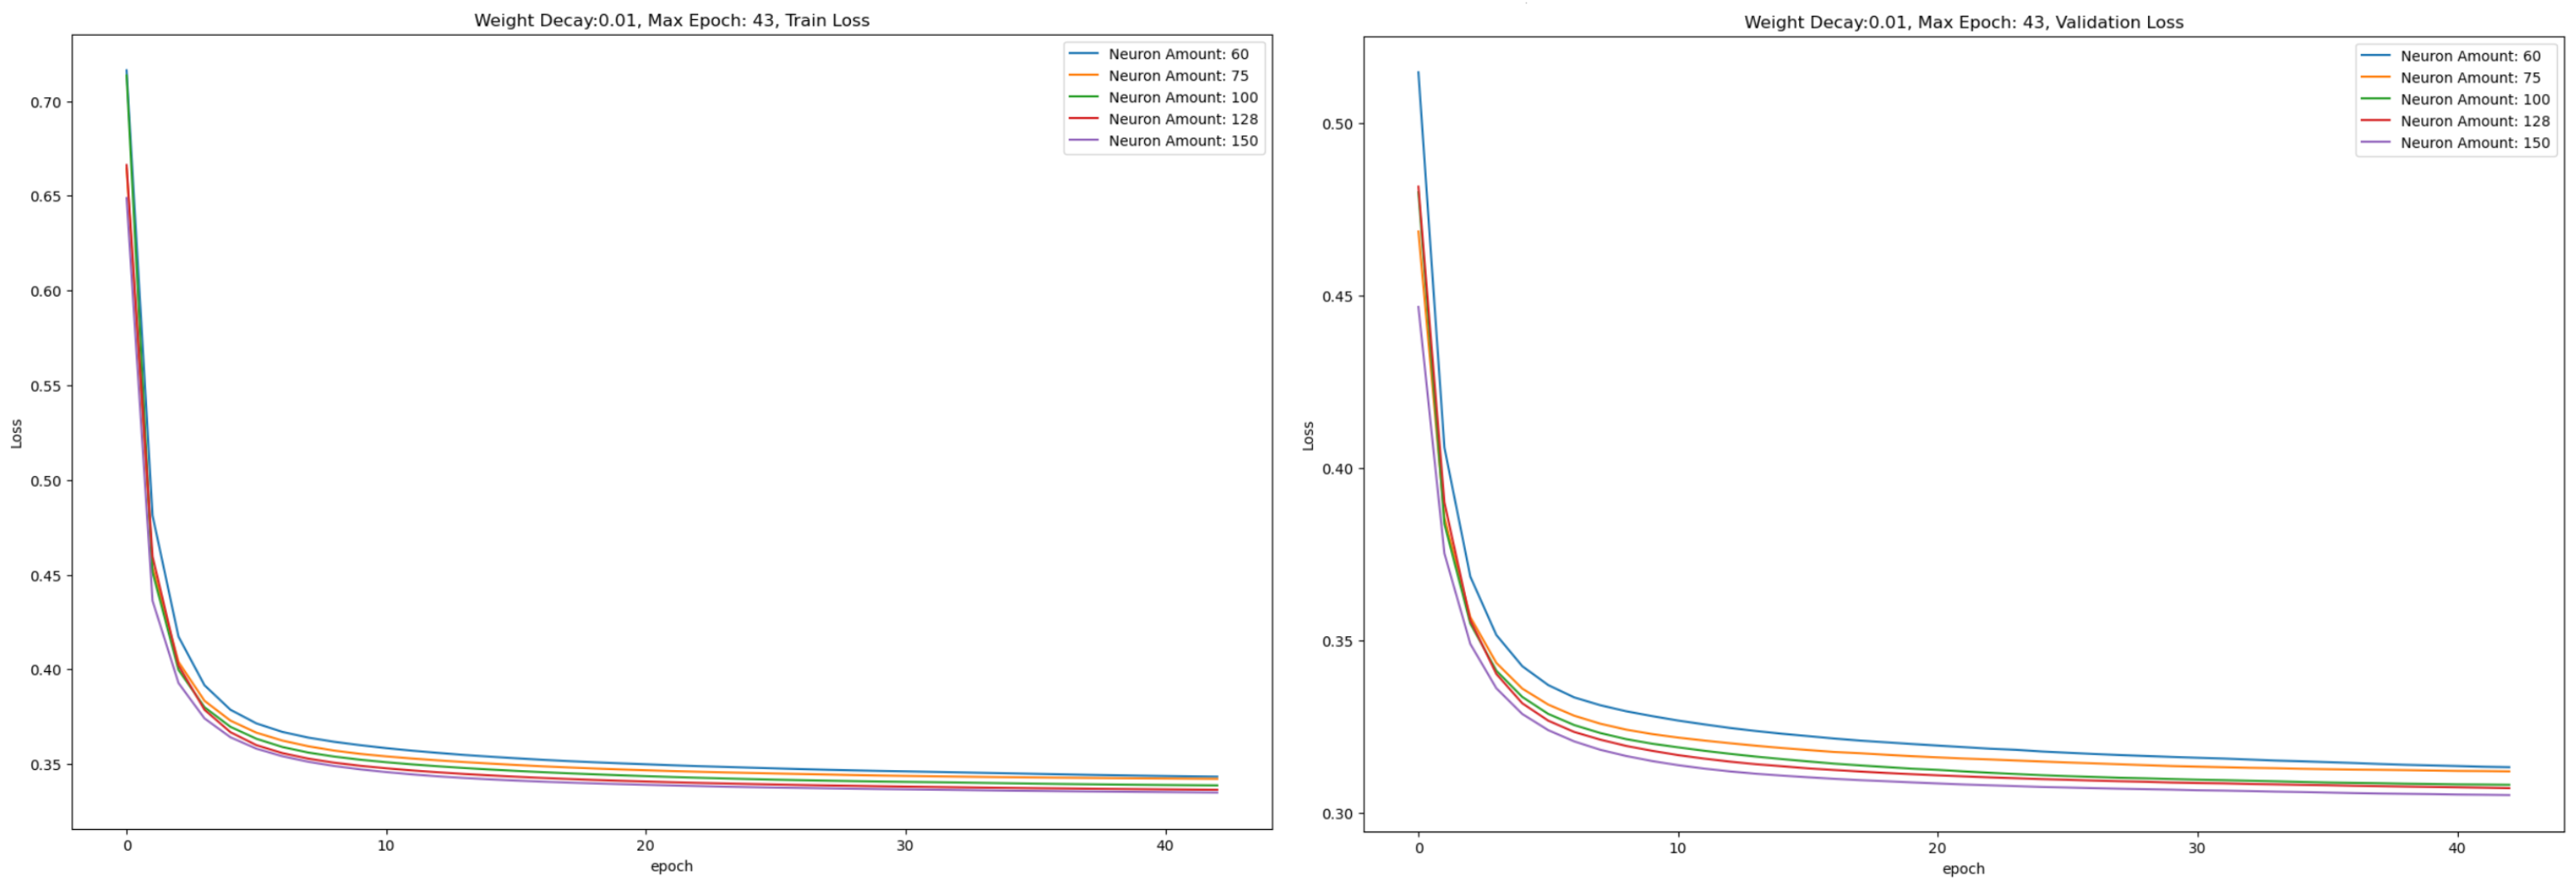
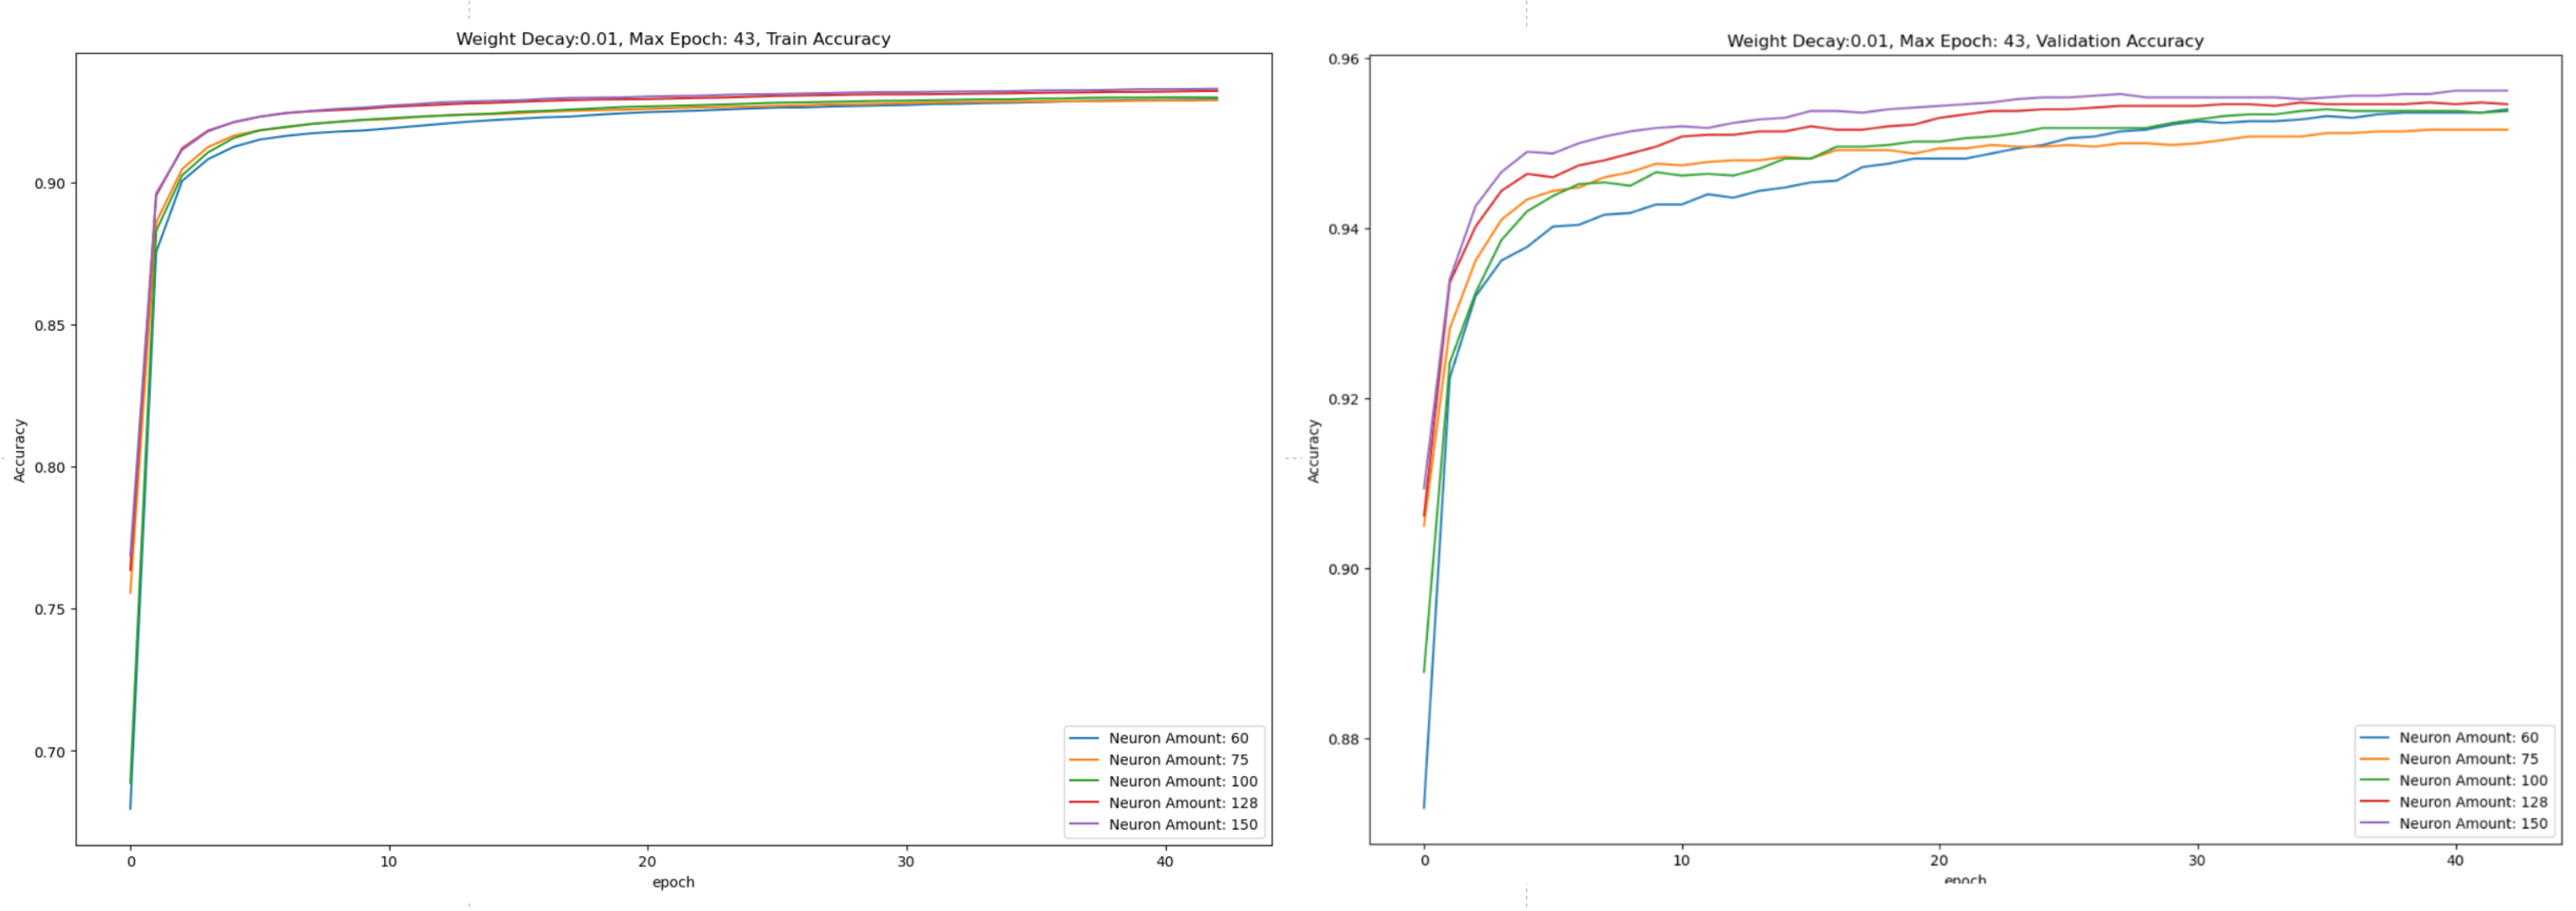

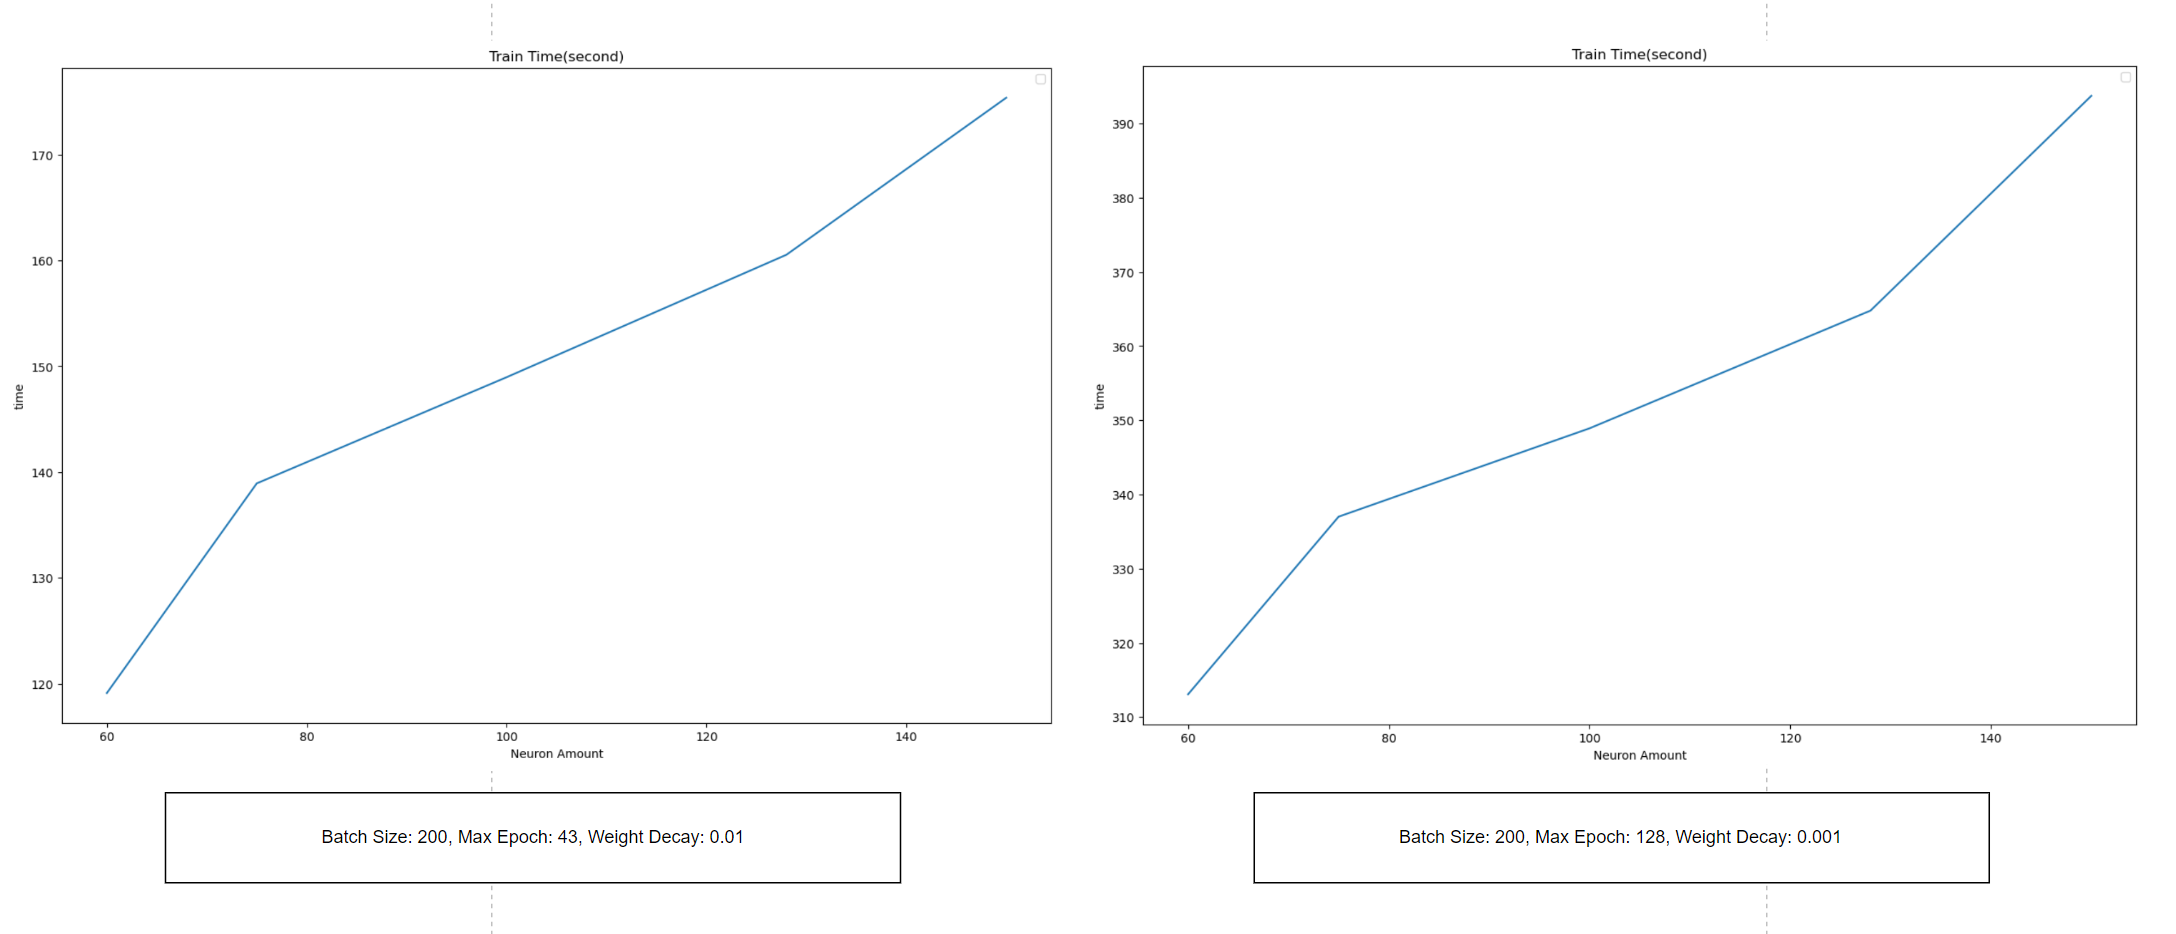

The best performance is with 150 neurons in the hidden layer with 128 epochs and weight decay at 0.001, despite it has the highest training cost

## 3. Paramter Tuning for MLP with Softmax Cross Entropy Loss

We will follow the same process of parameter tuning in Section 2. Some analysis will be omitted since we have already analyzed quite some details in Section 2. 

### 3.1 Batch size
### 3.1.1 MLP with Softmax Cross Entropy Loss and Sigmoid Activation
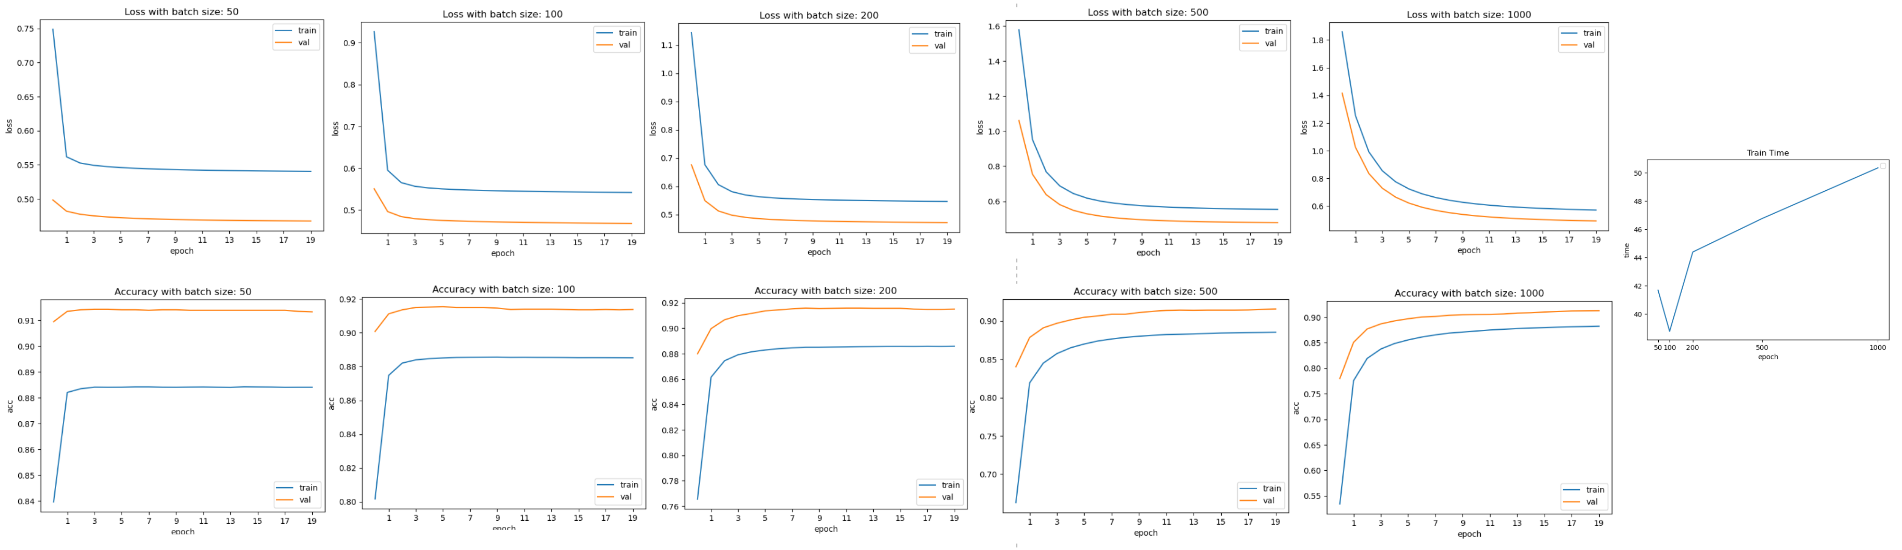
### 3.1.2 MLP with Softmax Cross Entropy Loss and ReLU Activation
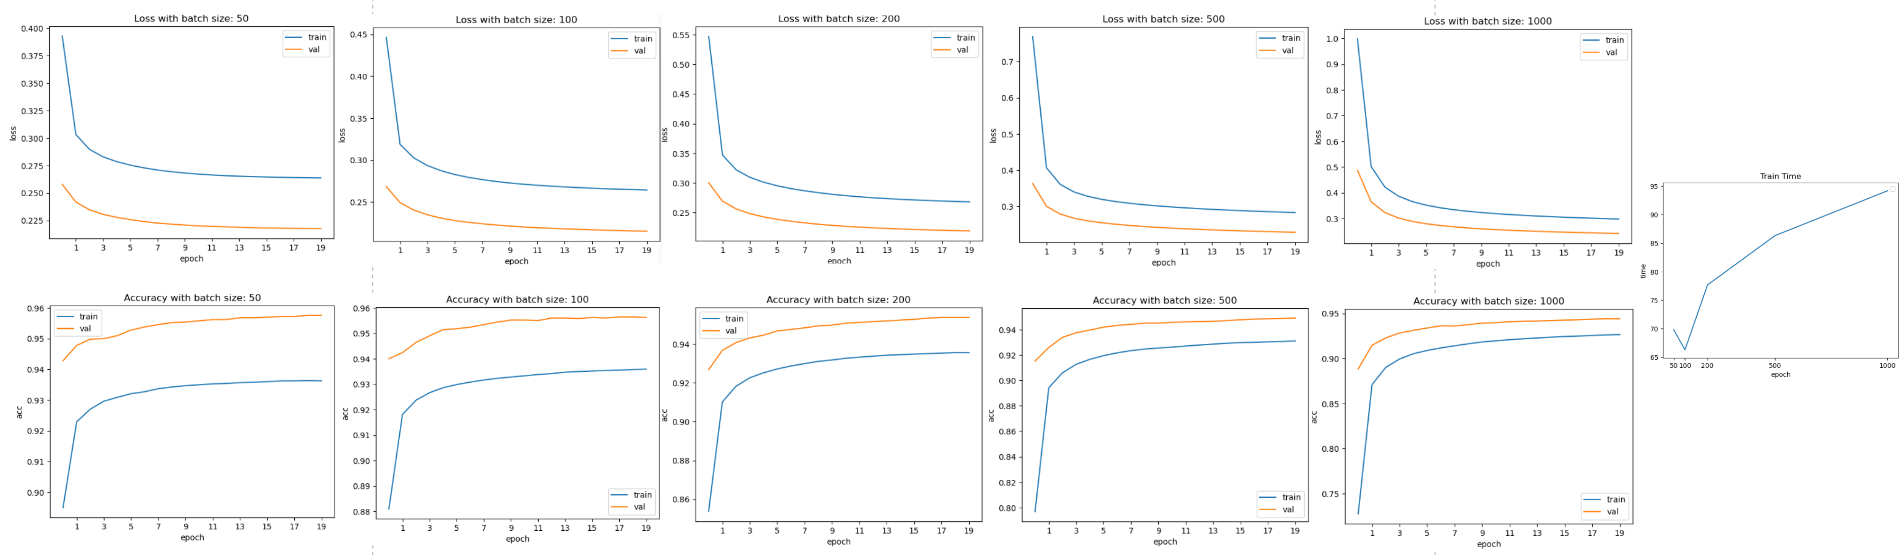  

ref: https://stats.stackexchange.com/questions/316464/how-does-batch-size-affect-convergence-of-sgd-and-why  

1. ReLU activation takes more training cost but carries out better performance than Sigmoid activation. Loss with ReLU are down to 0.3 and Sigmoid are mostly above 0.5. 
2. The larger the batch size, the slower the network convrges. The size of mini-batches is essentially the frequency of updates: the smaller minibatches the more updates. Geometrically, several updates is better because you are drawing several segments, each in the direction of the (approximated) gradient at the start of each segment. while a single big update is a single segment from the very start in the direction of the (exact) gradient. It's better to change direction several times even if the direction is less precise.
3. As the batch size increases, performance on the validation set and the performance on the train set start to approximate each other. A network with larger mini batch sizes usually have better generalization, that is, can estimate errors on the validtion set better. 
4. Smaller batch size with Sigmoid converges at around epoch 5-7, with a comparative high loss and low accuracy, due to potential underfitting. 
5. ReLU activation network has not fully converged within 20 epochs since loss curves in the diagrams all show a continuous downward trend. 
6. Best performance for Sigmoid is with batch size 200. It has the lowest training/validation loss and highest accuracy. Also, its curves are much smoother than with batch size 100, which has similar loss and accuracy on the train set.
7. ReLU's best result is with batch size 50. However, the rest of the networks haven't converged. Therefore, we will also test batch size 200 with higher epoch.


### 3.2 Max Epoch
### 3.2.1 MLP with Softmax Cross Entropy Loss and Sigmoid Activation
We use batch size 200(3.1.6) for testing.
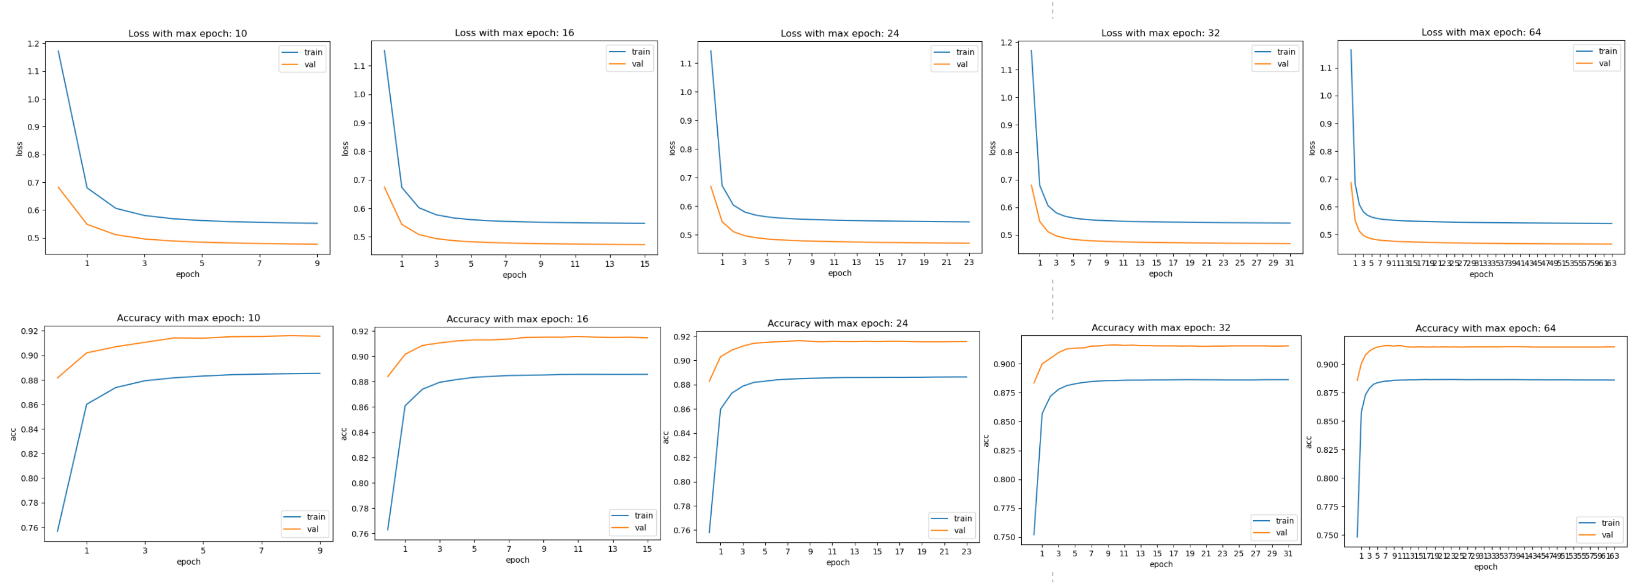

### 3.2.2 MLP with Softmax Cross Entropy Loss and ReLU Activation
####  batch size 50
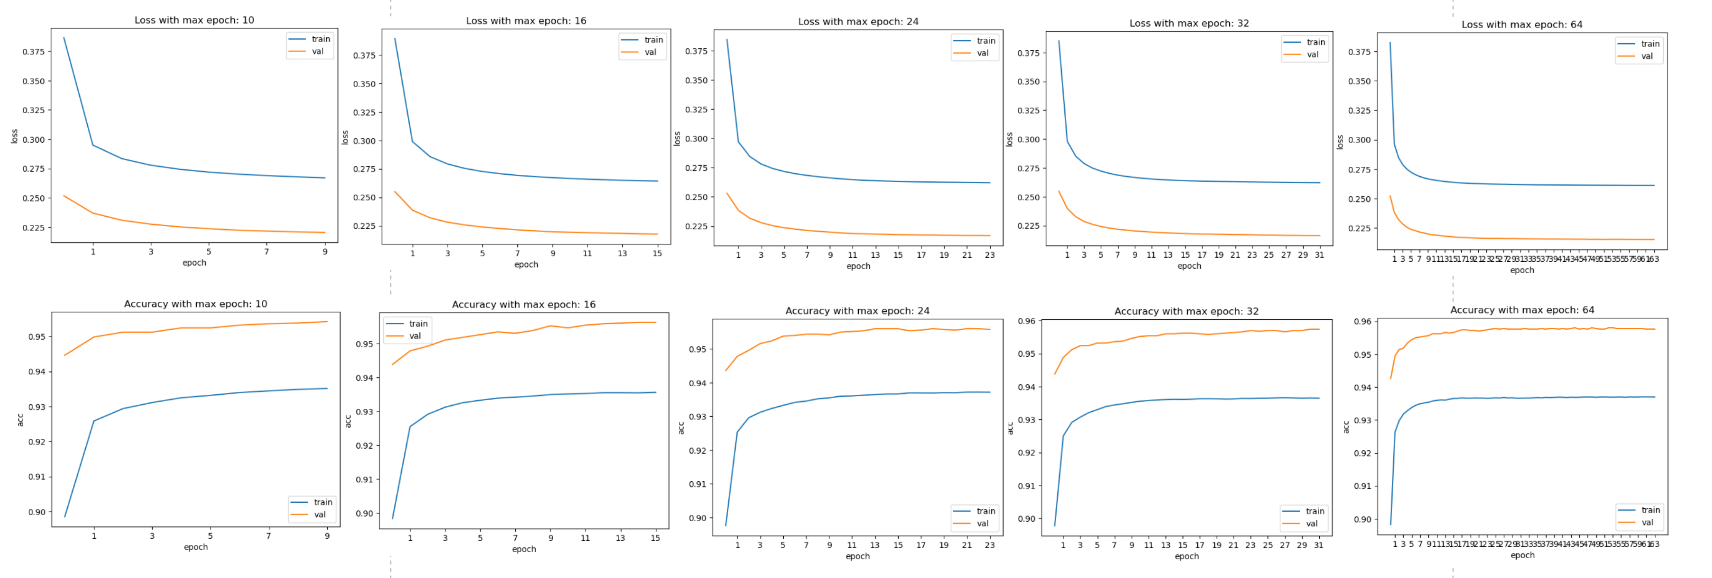

#### batch size 200
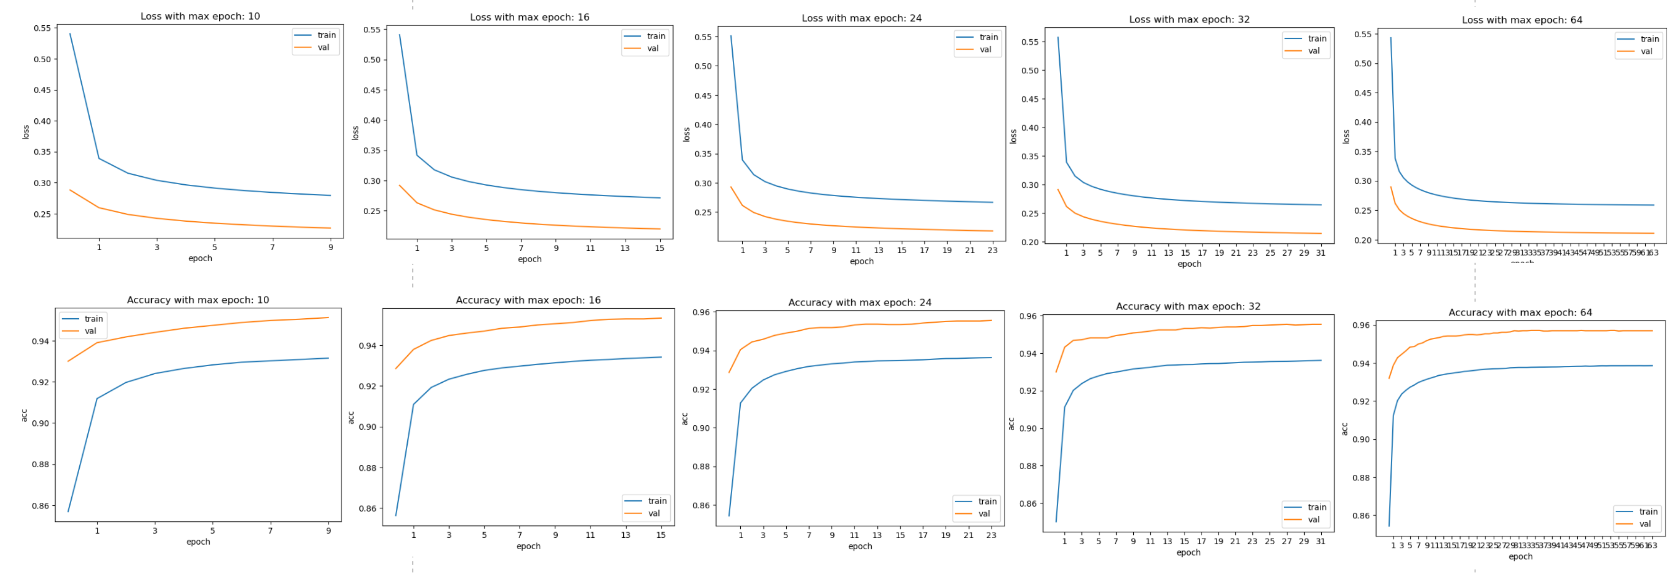

1. For Sigmoid activation, the loss and accuracy stop to change after converge. It carries out the similar training result as in the previous section.
2. ReLU activation still has better learnig results than Sigmoid.
3. Although the loss is down to 0.225 with batch size 50 using ReLU, much lower than batch size 200, batch size 200 still has an accuracy curve with far less fluctuations. Converge for batch size 200 roughly happens around epoch 48. 
4. In conclusion, using a one-hidden-layer MLP with ReLU activation and softmax loss works better on our data set. We will use this combination for later testing on neural unit amount, learning rate and weight decay.  


### 3.3 Learning Rate, Weight Decay and Neuron Amount
### 3.3.1 Learning Rate
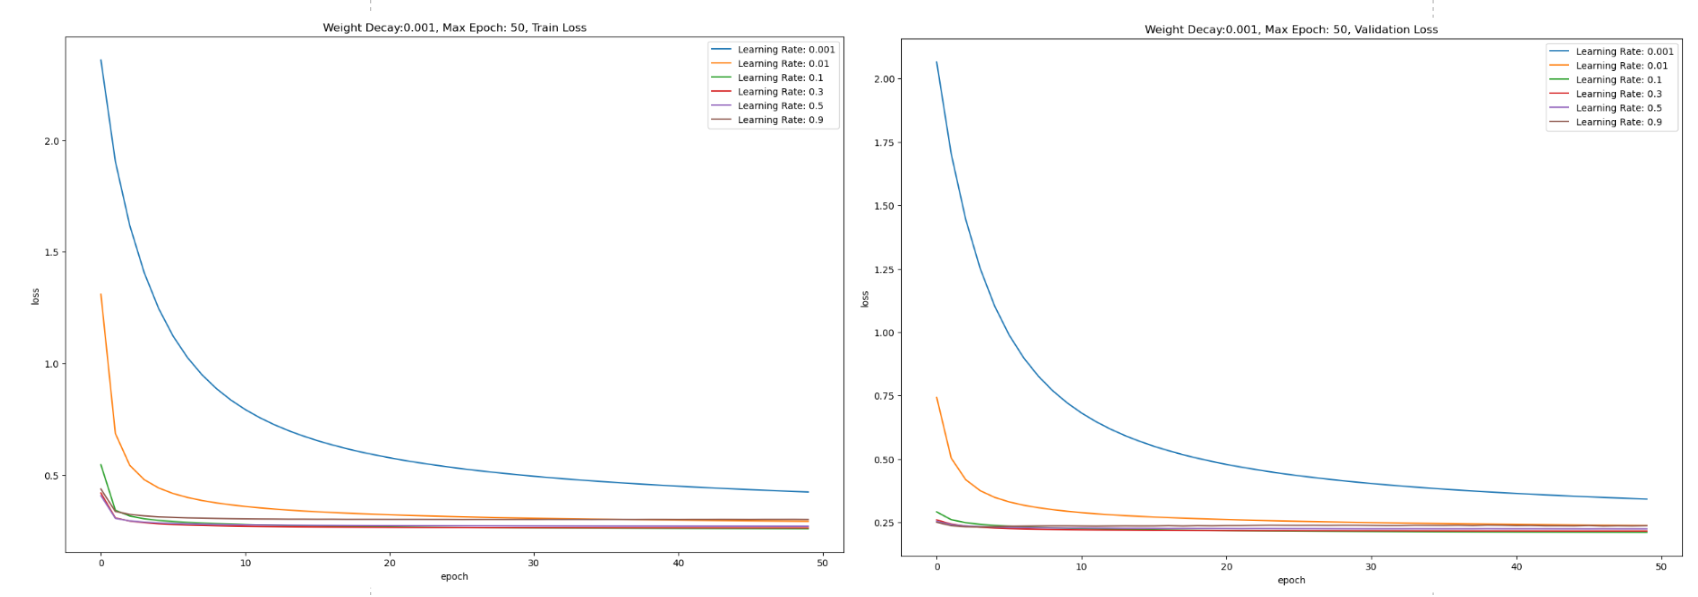
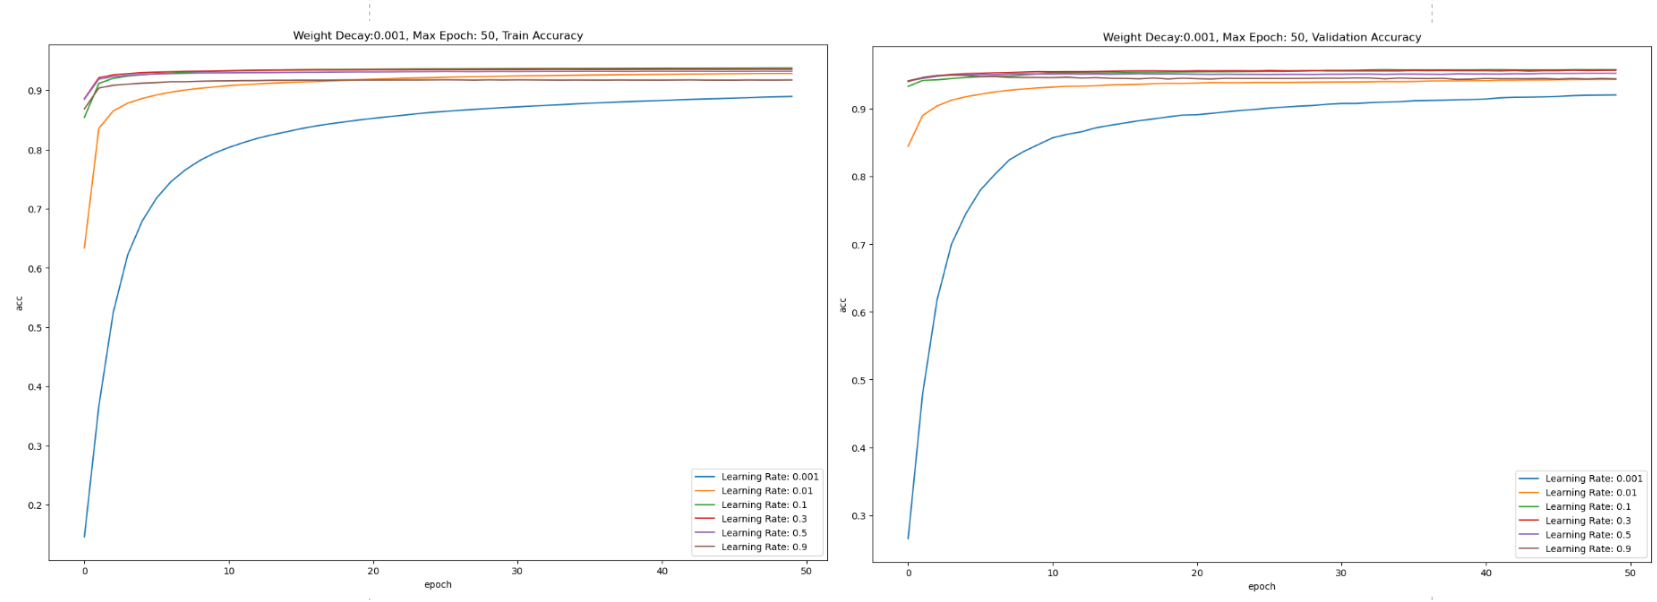
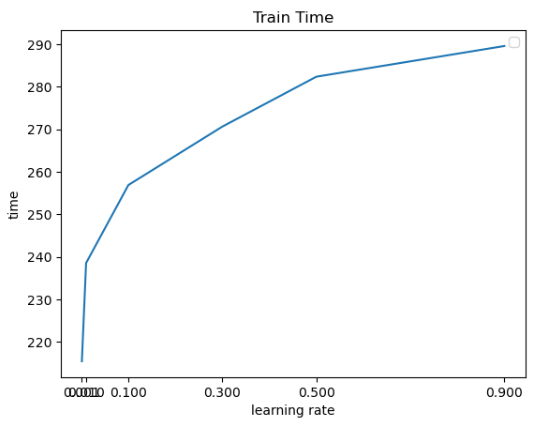

1. Learning rate at 0.001 carries out the worst performances on our data set. It makes the metwork slow to converge. Other learning rates' results are close.
2. Among all tested, learning rate 0.3 has the best learning results. It converges fast and has the highest prediction accuracy (mean: 0.955124). Therefore, we will use 0.3 as the learning rate for later testing.


### 3.3.2 Weight Decay
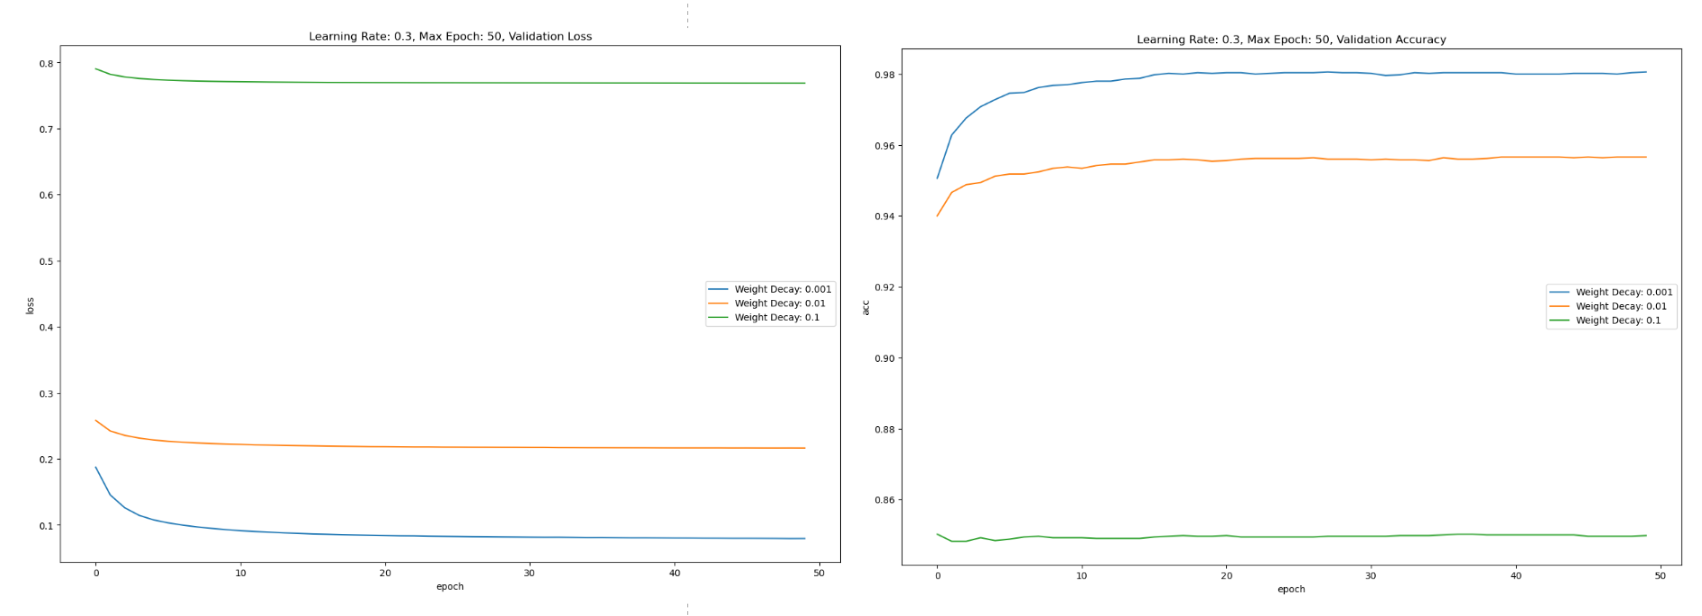
Weight decay 0.001 has the best performance. The decay value is small since our learning rate is comparatively high, and we need to do a proper trade-off to gaurantee both the convergence and the network behaviour.


### 3.3.3 Neuron Amount
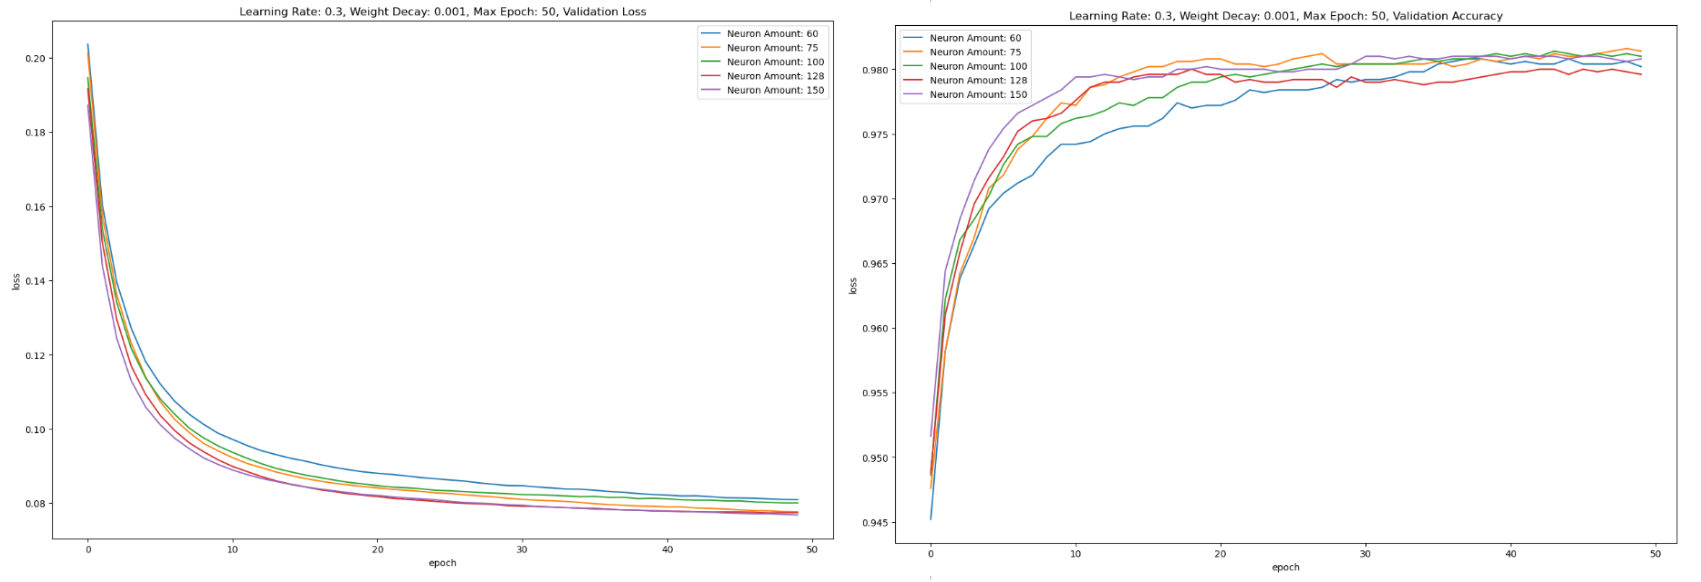
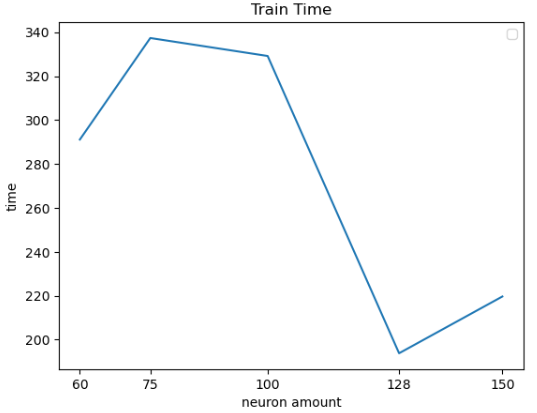

Same as the MLP with MSE and ReLU, neuron amount 150 has the lowest loss. However, neuron amount 75 has similar result and a bit higher accuracy at large epochs. Mean validation accuracy with 150 neurons is 0.97734 and with 75 neurons is 0.978. 75 neurons also has the highest traing cost.  
We will use both of these performances to compare with the best performance with MSE.

## 4. Compare Best Performances of One Hidden Layer

Below networks will be compared:
1. MSE+ReLU, Neuron 150, batch 200, epoch 128, learning rate 0.1, weight decay 0.001
2. Softmax+ReLU, Neuron 150, batch 200, epoch 50, learning rate 0.3, weight decay 0.001
3. Softmax+ReLU, Neuron 75, batch 200, epoch 50, learning rate 0.3, weight decay 0.001

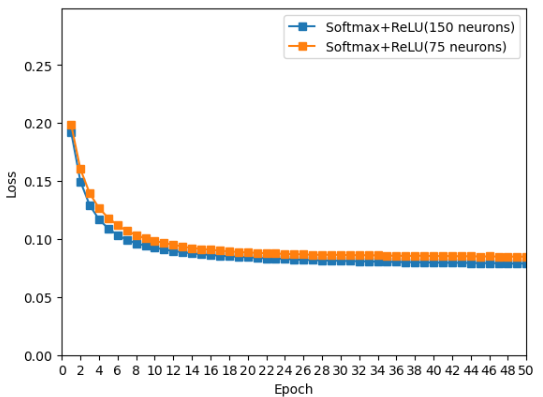 
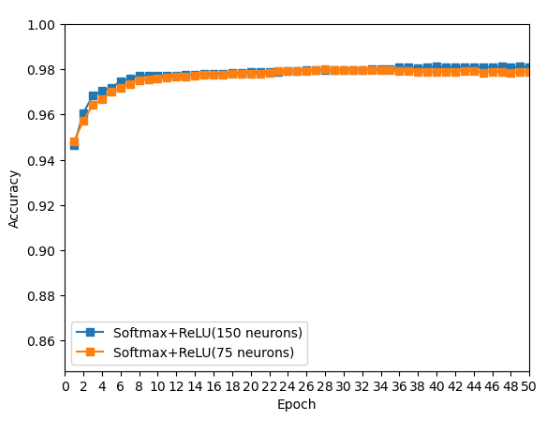
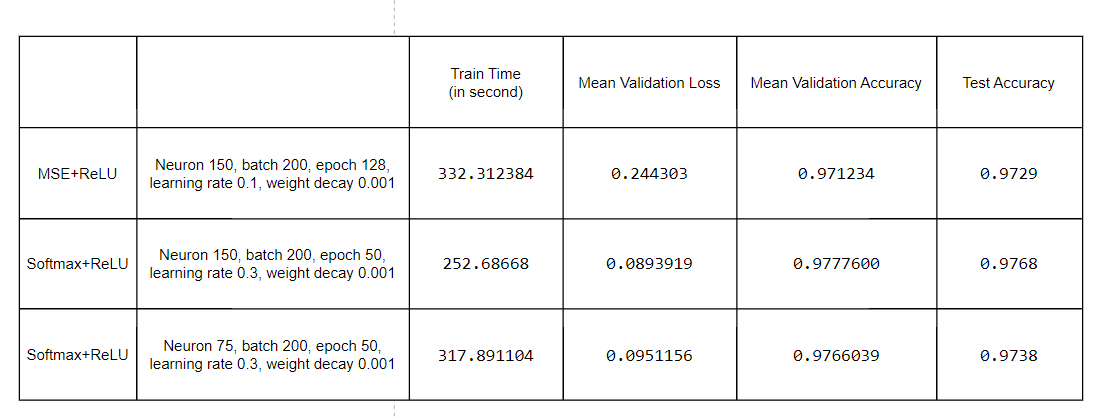

Analyzed from the diagrams above, Softmax+ReLU(Neuron 150, batch 200, epoch 50, learning rate 0.3, weight decay 0.001) has the best performance and lowest training cost. We wull use this one for conclusion, and the test set has accuracy at 0.9768.

## 5. MLP with Multiple Hidden Layers

We will use the softmax layers above for combination.

### 5.1 Two Hidden Layer with Softmax and ReLU

In [30]:
batch_size = 200
max_epoch = 50
init_std = 0.01

learning_rate_SGD = 0.3
weight_decay = 0.001

disp_freq = 10

criterion = SoftmaxCrossEntropyLossLayer()
sgd = SGD(learning_rate_SGD, weight_decay)

In [31]:
reluMLP = Network()
# 使用FCLayer和SigmoidLayer构建多层感知机
# 128为隐含层的神经元数目
reluMLP.add(FCLayer(784, 150))
reluMLP.add(ReLULayer())
reluMLP.add(FCLayer(150, 75))
reluMLP.add(ReLULayer())
reluMLP.add(FCLayer(75, 10))

In [32]:
reluMLP, relu_train_loss, relu_train_acc, relu_val_loss, relu_val_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)

In [33]:
test(reluMLP, criterion, data_test, batch_size, disp_freq)

Testing...
The test accuracy is 0.9792.



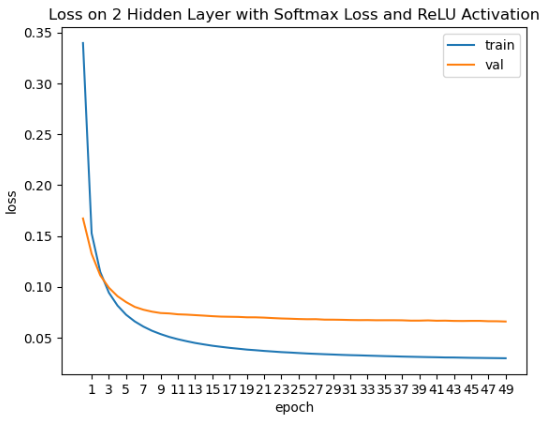
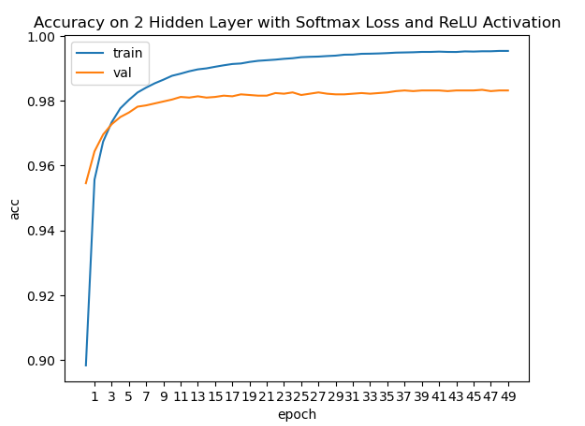

### 5.2 Two Hidden Layer with MSE and ReLU

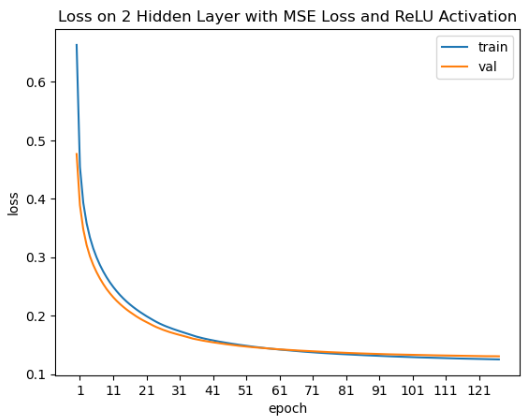
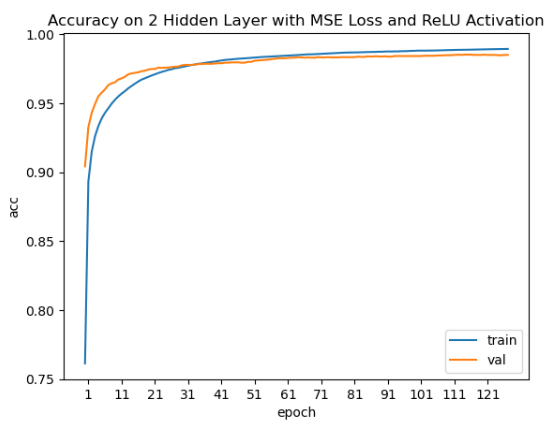

ref: https://medium.com/@Rohit_Varma/why-we-need-multi-layer-neural-network-mlp-d50425b8f37d

1. With two hidden layers, the network converges much faster than one hidden layer, at about 33. The accuracy and loss also improves. The loss on the train set starts to approximate 0.05 and accuarcy starts to approximate 1.0
2. The accuracy reaches 0.9801 on the test set. We also tested two hidden layers with MSE loss and ReLU activation, and the test accuracy reaches 0.9811. 
3. The model with more number of neurons per layer and more number of layer has higher representational capacity, in turn, is capable to map any complicated function OR Model is capable to extract any level complex features from out input datasets. The advantage of multiple layers is that they can learn features at various levels of abstraction. If we build a very wide, very deep network, we run the chance of each layer just memorizing what we want the output to be, and we end up with a neural network that fails to generalize to new data.

## 6. Conclusion

The optimal model we choose for one hidden layer has the parameters as following: learning rate 0.3, weight decay 0.001, batch size 200 and max epochs 50 with Softmax Cross Entropy loss and ReLU activation. The accuracy on the test set reaches to 0.9768. For two hidden layers, we tested both Softmax Cross Entropy loss and Euclidean loss with ReLU activation. Their accuracy scores both reach 0.98, among which MSE is slightly better with an accuracy at 0.9811.

The balance between batch size, max epoch, learning rate and weight decay, has decisive influences over the learning results. Neuron amount in one hidden layer, that is how wide a layer/model is, also has huge impact over the training results. If less number of neurons is chosen it will lead to underfitting and high statistical bias. Whereas if we choose too many neurons it may lead to overfitting, high variance, and increases the time it takes to train the network.

In our experiment, ReLU works generally better than Sigmoid. sigmoid outputs are not zero-centered. This is undesirable since neurons in later layers of processing in a Neural Network (more on this soon) would be receiving data that is not zero-centered. This has implications on the dynamics during gradient descent, because if the data coming into a neuron is always positive (e.g. x>0 elementwise in f=wTx+b)), then the gradient on the weights w will during backpropagation become either all be positive, or all negative (depending on the gradient of the whole expression f). This could introduce undesirable zig-zagging dynamics in the gradient updates for the weights.

With more time, we could try use early-stop strategy and Adam in the MLP and see how network behaves. Besides, given the two-hidden-layer networks with softmax and MSE have similar accuracy on the test set, we should run tests to check which one is better with statistical significance.